In [2]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd',
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c],
          sns.color_palette('Reds', n)[c],
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [3]:
def draw_maze(maze,
              maze_vals,
              show_nav=False,
              all_pos=None,
              draw_base=True,
              ax=None,
              **kws):
    """Convert maze_vals to a 2D map of the maze environment.."""
    _origin = np.tile(maze.origin, 2).reshape((2, 2))

    maze_map = np.zeros(maze.shape)
    for idx, val in maze_vals.items():
        maze_tile = np.array(maze.maze.iloc[int(idx)]['coords']) - _origin
        maze_map[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]), 
                             range(maze_tile[0][1], maze_tile[1][1]))] = val

    mask = np.zeros(maze.shape)
    for idx, row in maze.maze.query("(region=='wall')").iterrows():
        maze_tile = np.array(row['coords']) - _origin
        mask[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]), 
                         range(maze_tile[0][1], maze_tile[1][1]))] = 1

    # Generate the heatmap.
    if ax is None:
        ax = plt.gca()
    kws['vmin'] = kws.get('vmin', 0)
    kws['vmax'] = kws.get('vmax', np.nanmax(maze_map))
    kws['cmap'] = kws.get('cmap', ['#b2babf'] + sns.color_palette('rocket', 500))
    facecolor = kws.pop('facecolor', '#40291c')
    color_nav = kws.pop('color_nav', '#b2babf')
    alpha_nav = kws.pop('alpha_nav', 0.25)
    lw_nav = kws.pop('lw_nav', 0.3)
    color_base = kws.pop('color_base', '#b2babf')
    lw_base = kws.pop('lw_base', 1)
    cbar_label = kws.pop('cbar_label', '')
    cbar_labelpad = kws.pop('labelpad', 8)

    ax = sns.heatmap(maze_map.T, mask=mask.T, ax=ax, **kws)
    ax.set_facecolor(facecolor)
    if show_nav:
        for iTrial, trial in enumerate(all_pos.keys()):
            ax.plot(all_pos[trial][:, 0] - _origin[0], 
                    all_pos[trial][:, 1] - _origin[1], 
                    color='#b2babf', alpha=alpha_nav, linewidth=0.3)
    if draw_base:
        base_coords = np.array(maze.maze.query("(region=='base')")['coords'].tolist())
        base_points = np.concatenate((base_coords[:, 0, :], base_coords[:, 1, :]))
        base_min = (np.min(base_points, axis=0) - maze.origin)
        base_max = (np.max(base_points, axis=0) - maze.origin)
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, 
                                 fill=False, lw=lw_base, ec=color_base)
        ax.add_patch(rect)
        
    font = kws.get('font', {'tick': 12, 'label': 14, 'annot': 12, 'fig': 16})
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'])
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    cbar.set_label(cbar_label, 
                   fontsize=font['label'], 
                   labelpad=cbar_labelpad)

    return ax, maze_map, mask

def draw_maze_precise(maze,
                      maze_vals,
                      scaling_factor=1,
                      do_convolve=True,
                      show_nav=False,
                      all_pos=None,
                      draw_base=True,
                      cbar_label='',
                      ax=None,
                      **kws):
    """Convert maze_vals to a 2D map of the maze environment."""
    _origin = maze.origin * scaling_factor
    
    # Map values to the 2D maze.
    maze_map = np.zeros(maze.shape * scaling_factor)
    for point, val in maze_vals.items():
        point -= _origin
        maze_map[tuple(point)] = val
    
    # Mask out walls.
    mask = np.zeros(maze.shape * scaling_factor)
    for idx, row in maze.maze.query("(region=='wall')").iterrows():
        maze_tile = (np.array(row['coords']) * scaling_factor) - _origin
        mask[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]),
                         range(maze_tile[0][1], maze_tile[1][1]))] = 1
    
    # Convolve maze values with a 2D Gaussian, handling NaNs.
    if do_convolve:
        sigma = 2 * scaling_factor # m the subject can move in 0.5s
        kernel = Gaussian2DKernel(sigma, sigma)
        maze_map[maze_map==0] = np.nan
        maze_map = convolve(maze_map, kernel, mask=mask)
    
    # Make the heatmap.
    if ax is None:
        ax = plt.gca()
    kws['vmin'] = kws.get('vmin', 0)
    kws['vmax'] = kws.get('vmax', np.max(maze_map[np.isfinite(maze_map)]))
    kws['cmap'] = kws.get('cmap', ['#b2babf'] + sns.color_palette('rocket', 500))
    alpha_nav = kws.pop('alpha_nav', 0.3)
    labelpad = kws.pop('labelpad', 8)
    ax = sns.heatmap(maze_map.T, mask=mask.T, ax=ax, **kws)
    if show_nav:
        for iTrial, trial in enumerate(all_pos.keys()):
            ax.plot(all_pos[trial][:, 0] - _origin[0], 
                    all_pos[trial][:, 1] - _origin[1], 
                    color='#b2babf', alpha=alpha_nav, linewidth=0.3)
    if draw_base:
        base_coords = np.array(maze.maze.query("(region=='base')")['coords'].tolist())
        base_points = np.concatenate((base_coords[:, 0, :], base_coords[:, 1, :]))
        base_min = (np.min(base_points, axis=0) - maze.origin) * scaling_factor
        base_max = (np.max(base_points, axis=0) - maze.origin) * scaling_factor
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, 
                                 fill=False, lw=1, ec='#b2babf')
        ax.add_patch(rect)
    ax.set_facecolor('#40291c')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    cbar = ax.collections[0].colorbar
    font = kws.get('font', {'tick': 12, 'label': 14, 'annot': 12, 'fig': 16})
    cbar.ax.tick_params(labelsize=font['annot'])
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)

    return ax, maze_map, mask

## Maze config

In [4]:
# Load/save events for each session.
save_output = 0
overwrite = 0
run_all = 0
remove_bad_trials = 1
verbose = 0
proj_dir = '/home1/dscho/projects/time_cells'

start_time = time()
warnings.filterwarnings('ignore')

sessions = np.sort([op.basename(f).split('-')[0] 
                    for f in glob(os.path.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])

events = od([])
event_spikes = od([])
for subj_sess in sessions:
    print(subj_sess)
    
    # Load events.
    events[subj_sess] = events_proc.load_events(subj_sess,
                                                run_all=run_all,
                                                remove_bad_trials=remove_bad_trials,
                                                overwrite=overwrite, 
                                                verbose=verbose)
    if not run_all:
        events[subj_sess].log_gold_view_events()
        events[subj_sess].log_gold_spawned()
        events[subj_sess].log_dig_events()
        
    if save_output:
        events_proc.save_events(events[subj_sess],
                                overwrite=overwrite,
                                verbose=verbose)
    
    # Load event_spikes.
    event_spikes[subj_sess] = time_bin_analysis.load_event_spikes(subj_sess, verbose=verbose)
        
warnings.resetwarnings()
print('Done in {:.1f}s'.format(time() - start_time))

U518_ses0
U518_ses1
U521_ses0
U526_ses0
U527_ses0
U530_ses0
U530_ses1
U532_ses0
U536_ses0
U537_ses0
U539_ses0
U540_ses0
Done in 4.6s


In [8]:
game_states = ['Encoding', 'Retrieval']

output = []
for subj_sess in sessions:
    subj = subj_sess.split('_')[0]
    for game_state in game_states:
        _event_spikes = event_spikes[sessions[0]].event_spikes.query("(gameState=='{}')".format(game_state)).copy()
        _col_map = event_spikes[sessions[0]].column_map
        
        place_renaming = {'place-Base'      : 'place-B',
                          'place-C_Hall'    : 'place-CH',
                          'place-NE_Hall'   : 'place-NEH',
                          'place-NE_Room'   : 'place-NER',
                          'place-NW_Hall'   : 'place-NWH',
                          'place-NW_Room'   : 'place-NWR',
                          'place-N_Passage' : 'place-NH',
                          'place-SE_Hall'   : 'place-SEH',
                          'place-SE_Room'   : 'place-SER',
                          'place-SW_Hall'   : 'place-SWH',
                          'place-SW_Room'   : 'place-SWR',
                          'place-S_Passage' : 'place-SH'}
        _event_spikes = _event_spikes.rename(columns=place_renaming)
        _col_map['place'] = ['place-B',   'place-SH',  'place-CH',  'place-NH',
                             'place-SWH', 'place-SWR', 'place-NWR', 'place-NWH',
                             'place-SEH', 'place-SER', 'place-NER', 'place-NEH']
        _col_map['hd'] = ['hd-N', 'hd-NE', 'hd-E', 'hd-SE',
                          'hd-S', 'hd-SW', 'hd-W', 'hd-NW']
        cols = _col_map['time'] + _col_map['place'] + _col_map['hd'] + _col_map['is_moving'] + _col_map['base_in_view']
        if game_state == 'Encoding':
            cols += _col_map['gold_in_view']
        elif game_state == 'Retrieval':
            cols += _col_map['dig_performed']
        _event_spikes = _event_spikes[cols]
        
        # Calculate Pearson correlation between each behavioral parameter.
        corrmat = _event_spikes.corr(method='pearson')
        output.append([subj, subj_sess, game_state, corrmat])
        
behav_corrs = pd.DataFrame(output, columns=['subj', 'subj_sess', 'gameState', 'corrs'])

In [9]:
_df = (behav_corrs.groupby(['subj', 'gameState'], sort=False)['corrs']
                  .apply(lambda x: np.mean(x.values))
                  .reset_index()
                  .rename(columns={'level_2': 'level'})
                  .groupby(['gameState', 'level'], sort=False).mean()
                  .reset_index(level='level'))
mean_corrs = {game_state: _df.loc[game_state].set_index('level')
              for game_state in game_states}

In [35]:
mean_corrs['Encoding'].iloc[10:22, :10]

time-1    time-2    time-3    time-4    time-5    time-6  \
level                                                                   
place-B    0.589310  0.126674 -0.134018 -0.181750 -0.181750 -0.159720   
place-SH  -0.054636  0.267109  0.115342 -0.091060 -0.084989 -0.066777   
place-CH  -0.089748 -0.077454  0.051636  0.088519  0.014753 -0.003688   
place-NH  -0.070705 -0.070705  0.005322  0.035733  0.028130  0.096554   
place-SWH -0.093323  0.126610  0.096889  0.007727 -0.033882 -0.057658   
place-SWR -0.102621 -0.086158  0.083963  0.045548 -0.036768  0.023597   
place-NWR -0.105302 -0.105302 -0.083812  0.066620  0.098855  0.029012   
place-NWH -0.078318 -0.078318 -0.078318 -0.015941  0.157328  0.088021   
place-SEH -0.096177  0.083430  0.129781  0.031286 -0.049827 -0.073002   
place-SER -0.105006 -0.105006  0.024232  0.094236  0.029617  0.051157   
place-NER -0.100808 -0.100808 -0.084100  0.038430  0.177667  0.066277   
place-NEH -0.065795 -0.065795 -0.065795 -0.033304 -0.000812  0.169768   

             time-7    time-8        time-9   time-10  
level                                                  
place-B   -0.115659 -0.056912  1.652272e-02  0.097300  
place-SH  -0.084989  0.024283  1.358644e-15 -0.024283  
place-CH   0.076224  0.008606  8.605986e-03 -0.077454  
place-NH   0.050938 -0.017486 -2.280806e-03 -0.055500  
place-SWH -0.051714  0.001783  1.783240e-03  0.001783  
place-SWR  0.034573 -0.003841  7.134076e-03  0.034573  
place-NWR -0.013969  0.034384  5.587446e-02  0.023639  
place-NWH  0.039505  0.004852 -3.673301e-02 -0.002079  
place-SEH -0.026651 -0.061414  8.111294e-03  0.054462  
place-SER -0.008077  0.061927  2.423219e-02 -0.067312  
place-NER  0.110833 -0.022835 -7.296051e-02 -0.011696  
place-NEH  0.096662  0.072293 -4.142659e-02 -0.065795

In [38]:
np.sort(mean_corrs['Encoding'].iloc[10:22, :10].values.flatten())[:5]

array([-0.18174992, -0.18174992, -0.15971963, -0.13401762, -0.11565904])

-0.6 0.6


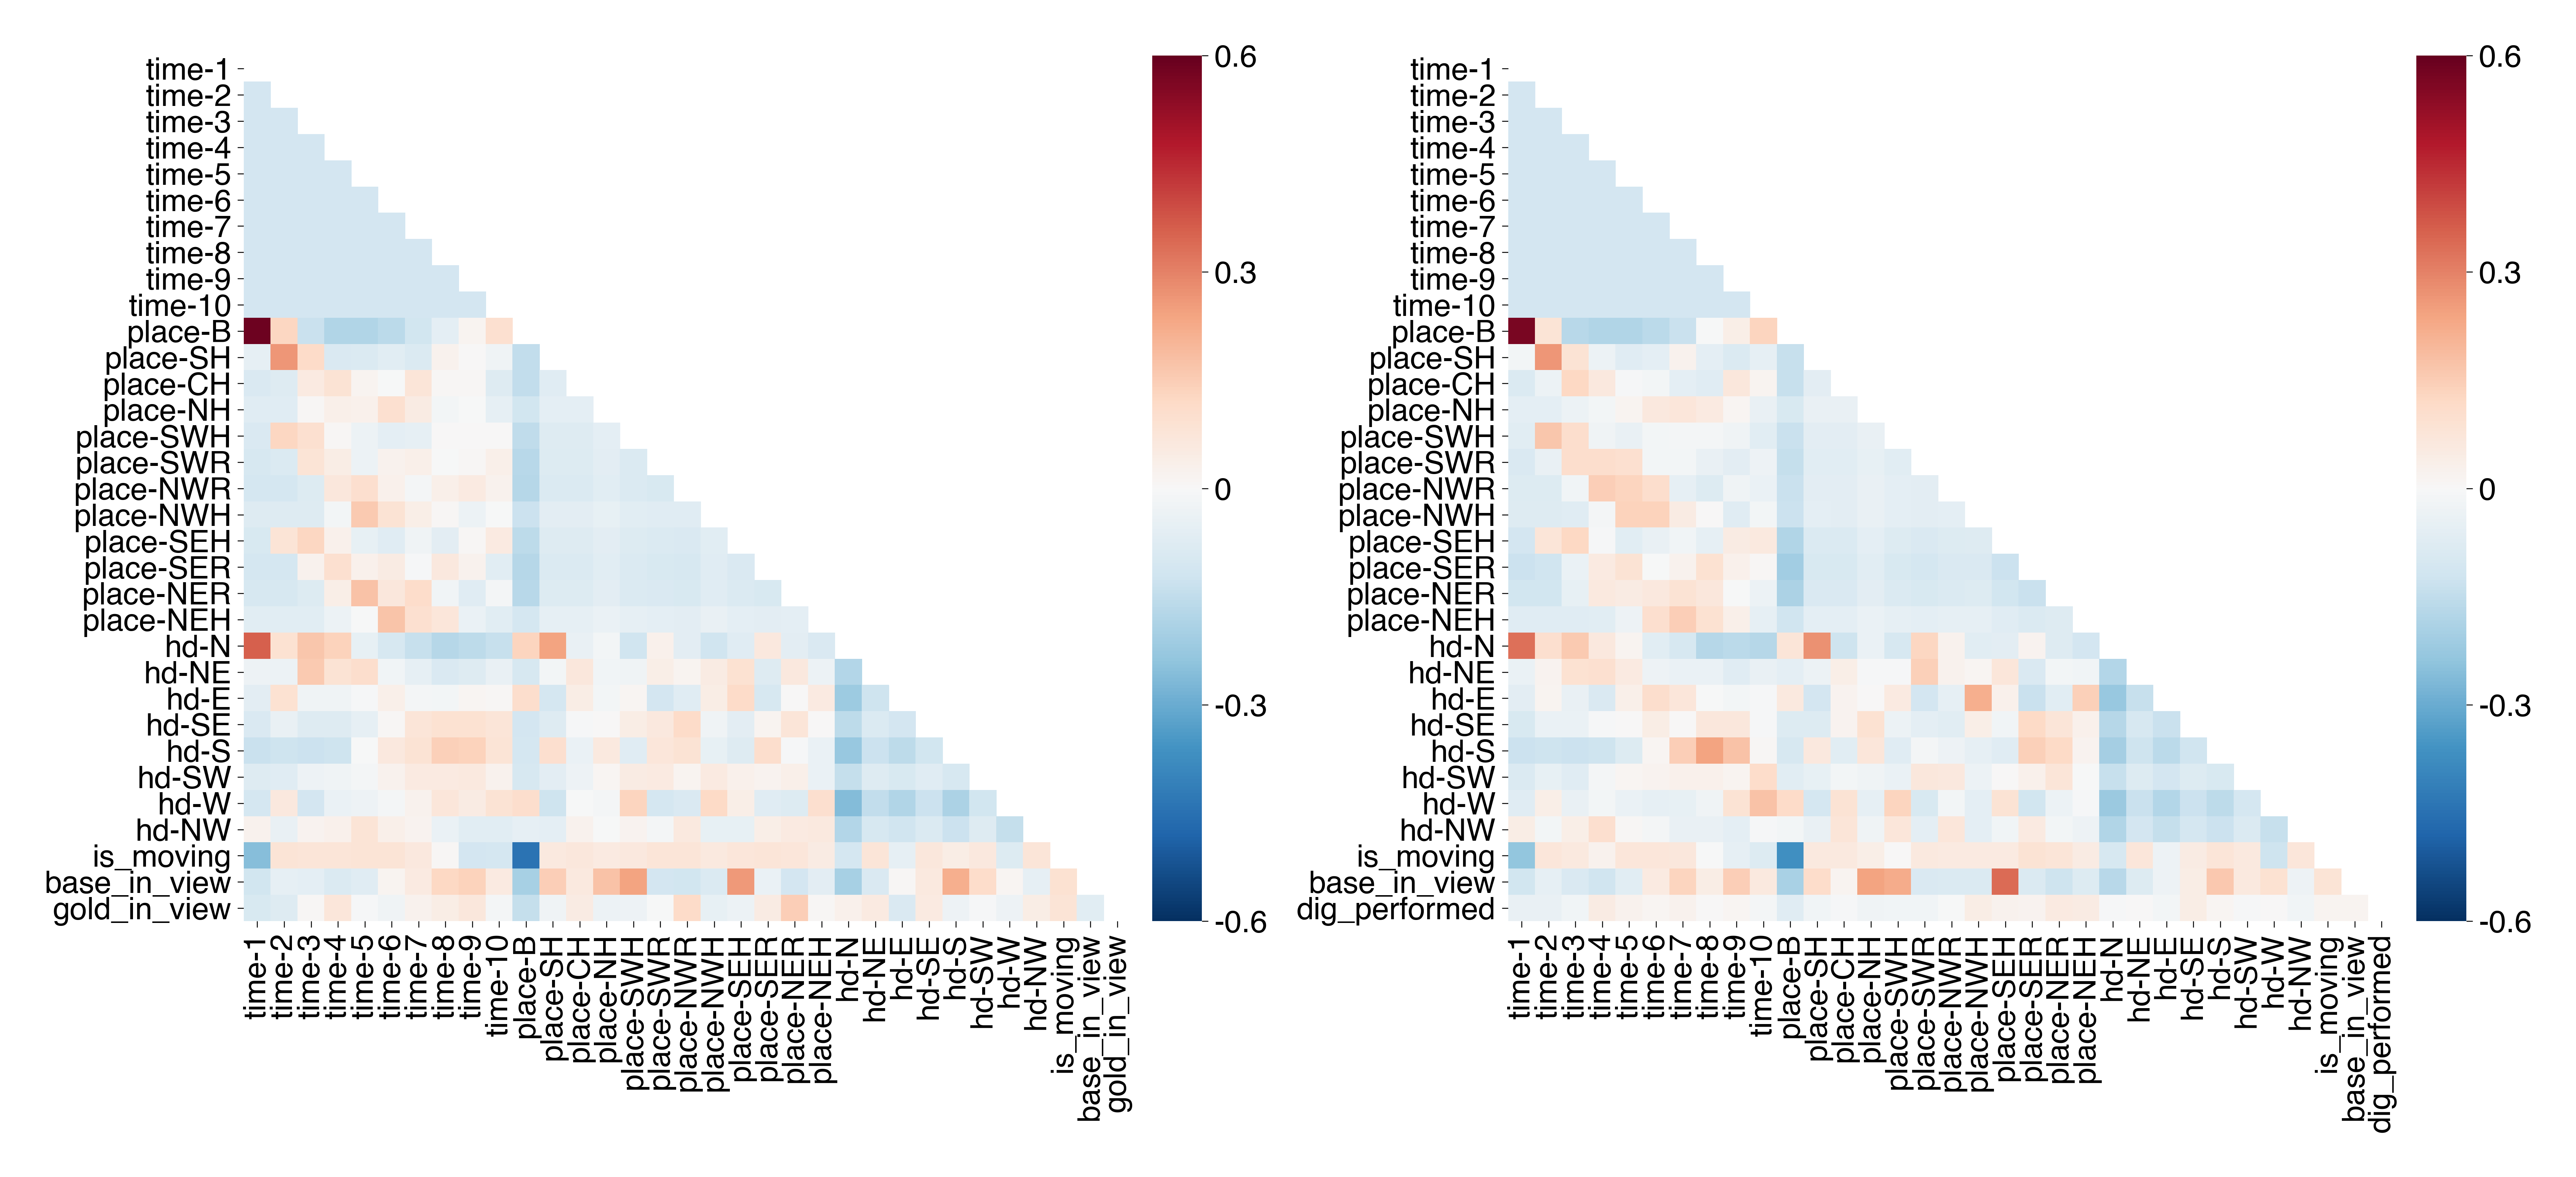

In [10]:
savefig = 0
overwrite = 0
game_states = ['Encoding', 'Retrieval']
colws = {1: 2.05, 2: 3.125, 3: 6.45}
grid_shp = (50, 125)
figsize = (colws[3], colws[3] * (grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7}
ticklength = 1
tickwidth = 0.15
tickpad = 1
labelpad = 1.5
cbar_label = None
cmap = 'RdBu_r'

vmax = np.round(np.max([np.nanmax(np.tril(np.abs(mean_corrs[game_state]), k=-1)) for game_state in game_states]), 1)
vmin = -vmax
print(vmin, vmax)

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 51), rowspan=50, colspan=3),
      plt.subplot2grid(grid_shp, (0, 71), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 122), rowspan=50, colspan=3)]

for igs, game_state in enumerate(game_states):
    iax = 2 * igs
    keep_cols = mean_corrs[game_state].columns[np.where(np.all(np.isfinite(mean_corrs[game_state]), axis=0))[0]]
    corr_mat = mean_corrs[game_state][keep_cols]
    mask = np.zeros(corr_mat.shape)
    mask[np.triu_indices(corr_mat.shape[0], k=0)] = 1
    sns.heatmap(corr_mat, ax=ax[iax], cbar=True, cbar_ax=ax[iax+1],
                vmin=vmin, vmax=vmax, cmap=cmap, mask=mask)
    
    # Configure the colorbar.
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], length=ticklength, width=tickwidth, pad=tickpad)
    cbar_ticks = np.linspace(vmin, vmax, 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)

    # Tweak other plot params.
    ax[iax].tick_params(axis='both', which='both', length=ticklength, width=tickwidth, pad=tickpad)
    xticks = list(corr_mat.columns)
    yticks = list(corr_mat.index)
    ax[iax].set_xticks(np.arange(len(xticks)) + 0.5)
    ax[iax].set_xticklabels(xticks, fontsize=font['tick'])
    ax[iax].set_yticks(np.arange(len(yticks)) + 0.5)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')
    ax[iax].set_facecolor('w')

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_behav',
                       'behav_param_corr_matrix-Encoding_Retrieval-{}subjs.pdf'
                       .format(behav_corrs['subj'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [9]:
print('BAD TRIALS')
n_subjs = np.unique([subj_sess.split('_')[0] for subj_sess in sessions]).size
n_sess = len(sessions)
n_trials = 0
n_bad_trials = 0
for subj_sess in sessions:
    n_trials += len(events[subj_sess].trials)
    if events[subj_sess].bad_trials:
        n_bad_trials += len(events[subj_sess].bad_trials)
        print(subj_sess)
        for trial, trial_phases in events[subj_sess].bad_trial_phases:
            print('\t{}, {}'.format(trial, trial_phases))
            
print('Across {} subjects and {} sessions, we included {}/{} ({:.1%}) trials in the analysis.'.format(n_subjs,
                                                                                                      n_sess,
                                                                                                      n_trials - n_bad_trials,
                                                                                                      n_trials,
                                                                                                      (n_trials - n_bad_trials) / n_trials))

BAD TRIALS
U518_ses1
	4, ['ReturnToBase1']
	31, ['Delay1', 'Delay2', 'DoNextTrial', 'Encoding', 'EndOfTrial', 'InitTrial', 'Retrieval', 'ReturnToBase1', 'ReturnToBase2']
U521_ses0
	17, ['ReturnToBase2']
U532_ses0
	4, ['Retrieval']
	24, ['Delay1']
	30, ['Delay1']
U539_ses0
	7, ['Delay2', 'Encoding']
	17, ['Delay1']
Across 10 subjects and 12 sessions, we included 424/432 (98.1%) trials in the analysis.


In [193]:
game_states = ['Encoding', 'Retrieval']

pct_moving = {game_state: [] for game_state in game_states}
for subj_sess in events:
    _positions = events[subj_sess].positions
    moved = _positions.query("(gameState=={})".format(game_states)).groupby('gameState')['moved_pos'].mean()
    for game_state in game_states:
        pct_moving[game_state].append(moved[game_state])

In [6]:
print('Time spent moving', '-' * 17, sep='\n')
for game_state in game_states:
    print('{}: {:.1%} ± {:.1%}'.format(game_state, np.mean(pct_moving[game_state]), stats.sem(pct_moving[game_state])))

In [7]:
idx = np.where(events['U532_ses0'].events['value'].apply(lambda x: "'scoreChange': 10," in str(x)))[0]
n_digs = events['U532_ses0'].events.query("(key=='dig')").shape[0]
gold_dug = events['U532_ses0'].events.iloc[idx].shape[0]

print('{}/{} ({:.1%})'.format(gold_dug, n_digs, gold_dug/n_digs))

In [9]:
_events.dig_events['dig_success'].mean(), gold_dug / len(_events.dig_events)

(0.29411764705882354, 0.29411764705882354)

In [ ]:
subj_performance = pd.DataFrame([['U518': 25,
                                  'U521': 9,
                                  'U526': 32,
                                  'U527': 46,
                                  'U530': 15,
                                  'U532': 49,
                                  'U536': 32,
                                  'U537': 15,
                                  'U539': 12,
                                  'U540': 18]],
                                columns=['subj', 'gold_dug'])

In [34]:
# How many golds were spawned, viewed, and dug in each session?
n_trials = []
gold_spawned = []
min_gold = []
max_gold = []
mean_gold = []
gold_viewed = []
gold_dug = []
dig_acc = []
for subj_sess in sessions:
#     _events = events[subj_sess]
    _events = events_proc.load_events(subj_sess, verbose=0)
    n_trials.append(_events.gold_spawned['trial'].unique().size)
    gold_spawned.append(_events.gold_spawned['gold_id'].unique().size)
    gold_per_trial = _events.gold_spawned.groupby('trial').size()
    min_gold.append(np.min(gold_per_trial))
    max_gold.append(np.max(gold_per_trial))
    mean_gold.append(np.mean(gold_per_trial))
    gold_viewed.append(_events.gold_events.query("(in_view==True)")['gold_id'].unique().size)
    gold_dug.append(len(_events.dig_events.query("(dig_success==True)")))
    dig_acc.append(_events.dig_events['dig_success'].mean())
    print('{}: {} trials {} gold spawned ({}-{}/trial, mean {:.1f}), {}/{} ({:.1%}) viewed, {:>2}/{} ({:.1%}) dug, {:.1%} digging accuracy'
          .format(subj_sess, n_trials[-1], gold_spawned[-1], min_gold[-1], max_gold[-1], mean_gold[-1],
                  gold_viewed[-1], gold_spawned[-1], gold_viewed[-1] / gold_spawned[-1],
                  gold_dug[-1], gold_viewed[-1], gold_dug[-1] / gold_viewed[-1], dig_acc[-1]))

print('', 'Across sessions', '-' * 15,
      'gold_spawned: mean = {:.1f} (range {}-{})'.format(np.mean(gold_spawned), np.min(gold_spawned), np.max(gold_spawned)),
      'gold_viewed: mean = {:.1f} (range {}-{})'.format(np.mean(gold_viewed), np.min(gold_viewed), np.max(gold_viewed)),
      'gold_dug: mean = {:.1f} (range {}-{})'.format(np.mean(gold_dug), np.min(gold_dug), np.max(gold_dug)),
      'dig_acc: mean = {:.1%} (range {:.1%}-{:.1%})'.format(np.mean(dig_acc), np.min(dig_acc), np.max(dig_acc)), sep='\n')

U518_ses0: 36 trials 40 gold spawned (1-2/trial, mean 1.1), 34/40 (85.0%) viewed, 13/34 (38.2%) dug, 34.2% digging accuracy
U518_ses1: 34 trials 58 gold spawned (1-4/trial, mean 1.7), 52/58 (89.7%) viewed, 32/52 (61.5%) dug, 56.1% digging accuracy
U521_ses0: 35 trials 39 gold spawned (1-2/trial, mean 1.1), 26/39 (66.7%) viewed,  9/26 (34.6%) dug, 25.7% digging accuracy
U526_ses0: 36 trials 59 gold spawned (1-3/trial, mean 1.6), 48/59 (81.4%) viewed, 32/48 (66.7%) dug, 71.1% digging accuracy
U527_ses0: 36 trials 71 gold spawned (1-3/trial, mean 2.0), 67/71 (94.4%) viewed, 46/67 (68.7%) dug, 63.9% digging accuracy
U530_ses0: 36 trials 38 gold spawned (1-2/trial, mean 1.1), 26/38 (68.4%) viewed, 10/26 (38.5%) dug, 55.6% digging accuracy
U530_ses1: 36 trials 48 gold spawned (1-2/trial, mean 1.3), 43/48 (89.6%) viewed, 20/43 (46.5%) dug, 48.8% digging accuracy
U532_ses0: 33 trials 65 gold spawned (1-4/trial, mean 2.0), 60/65 (92.3%) viewed, 44/60 (73.3%) dug, 41.5% digging accuracy
U536_ses

In [35]:
gold_viewed = np.array(gold_viewed)
gold_dug = np.array(gold_dug)

gold_viewed_ = np.concatenate(([gold_viewed[:2].mean()], gold_viewed[2:5], [gold_viewed[5:7].mean()], gold_viewed[7:]))
gold_dug_ = np.concatenate(([gold_dug[:2].mean()], gold_dug[2:5], [gold_dug[5:7].mean()], gold_dug[7:]))

print('{:.0%} ± {:.0%} (min={:.0%}, max={:.0%}) of viewed gold was dug (across subjects)'
      .format(np.mean(gold_dug_ / gold_viewed_),
              stats.sem(gold_dug_ / gold_viewed_),
              np.min(gold_dug_ / gold_viewed_),
              np.max(gold_dug_ / gold_viewed_)))

54% ± 4% (min=35%, max=73%) of viewed gold was dug (across subjects)


In [15]:
len(gold_dug)

12

In [18]:
sessions[5:7]

array(['U530_ses0', 'U530_ses1'], dtype='<U9')

In [24]:
gold_dug[5:7].mean()

15.0

In [ ]:
# Ranking view performance: U521, U537, U530, U526, U518, U536, U532, U527
# Ranking dig performance: U521, U537, U530, U518, U536, U526, U527, U532

In [8]:
# For what percent of encoding/retrieval trials was the subject 
# already back at the base when 30 sec were up?
def get_back_at_base(_events):
    df = _events.events.query("(trial=={})".format(_events.keep_trials))
    rtb_inds = np.array(df.query("(key=='gameState')")[df.query("(key=='gameState')")['value'].apply(lambda x: x['stateName']=='ReturnToBase')].index)
    position_inds = np.array(df.query("(key=='playerTransform')").index)

    x = np.expand_dims(rtb_inds, 1) - position_inds # rtb x position
    x[x<0] = 1e6
    back_at_base = df.loc[position_inds[x.argmin(axis=1)]].reset_index(drop=True)
    back_at_base['at_base'] = back_at_base['value'].apply(lambda x: 1 * x['playerAtBase']).tolist()
    
    if 'subj_sess' not in back_at_base:
        back_at_base['subj_sess'] = _events.subj_sess
        
    cols = ['subj_sess', 'trial', 'gameState', 'time_penalty', 'at_base']
    return back_at_base[cols]
    
back_at_base = pd.concat([get_back_at_base(events[subj_sess]) for subj_sess in events], axis=0)
back_at_base = back_at_base.groupby(['subj_sess', 'gameState', 'time_penalty']).agg({'at_base': np.mean}).reset_index()
back_at_base['at_base'] *= 100  # conv to percent

In [11]:
#events[subj_sess].time_penalty

In [20]:
rtb_times = []
for subj_sess in sessions:
    subj, sess = subj_sess.split('_')
    for game_state in ['ReturnToBase1', 'ReturnToBase2']:
        for idx, row in events[subj_sess].event_times.query("(gameState=='{}')".format(game_state)).iterrows():
            rtb_times.append([subj_sess, subj, sess, row['trial'], events[subj_sess].time_penalty[row['trial']], game_state, row['duration']])
cols = ['subj_sess', 'subj', 'sess', 'trial', 'time_penalty', 'gameState', 'duration']
rtb_times = pd.DataFrame(rtb_times, columns=cols)

def _pctls(vec):
    pctls = [90, 95, 100]
    return list(zip(pctls, np.round(np.percentile(vec, [90, 95, 100]), 0).astype(int).tolist()))
    
rtb_times.groupby('gameState').agg({'duration': [np.mean, np.std, median_q, _pctls]})

duration                                     \
                      mean          std              median_q   
gameState                                                       
ReturnToBase1  4422.625000  7828.116765  0.00 (0.00, 6869.25)   
ReturnToBase2  4260.110849  8580.841341  0.00 (0.00, 5429.00)   

                                                         
                                                 _pctls  
gameState                                                
ReturnToBase1  [(90, 13047), (95, 17719), (100, 67349)]  
ReturnToBase2  [(90, 13354), (95, 20283), (100, 58565)]

In [57]:
# Number of trials with RTB > 0, 2, 5, 10s.
rtb_times.groupby(['subj_sess', 'gameState'])['duration'].apply(lambda x: '{:>2}  {:>2}  {:>2}  {:>2}'.format(np.sum(x>0), np.sum(x>2000), np.sum(x>5000), np.sum(x>10000)))

subj_sess  gameState    
U518_ses0  ReturnToBase1    21  18  13   7
           ReturnToBase2    19  17  10   4
U518_ses1  ReturnToBase1    22  18  11   1
           ReturnToBase2    16  14   9   2
U521_ses0  ReturnToBase1    25  24  23  14
           ReturnToBase2    29  29  27  21
U526_ses0  ReturnToBase1     8   4   3   2
           ReturnToBase2     3   2   0   0
U527_ses0  ReturnToBase1    17   8   4   2
           ReturnToBase2     6   5   3   0
U530_ses0  ReturnToBase1    11   9   6   6
           ReturnToBase2    13  11   9   8
U530_ses1  ReturnToBase1    15  11   7   2
           ReturnToBase2    22  16  12   4
U532_ses0  ReturnToBase1    12   8   4   2
           ReturnToBase2     6   3   3   1
U536_ses0  ReturnToBase1    21  21  18   9
           ReturnToBase2    17  15  11   4
U537_ses0  ReturnToBase1    21  19  14   7
           ReturnToBase2    23  20  16  11
Name: duration, dtype: object

In [53]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=1200)
ax = np.ravel(ax)

iax = 0
for game_state in rtb_times['gameState'].unique():
    _df = rtb_times.query("(gameState=='{}')".format(game_state)).copy()
    _df['duration'] *= 1e-3
    sns.lineplot(x='trial', y='duration', hue='subj_sess', data=_df, ax=ax[iax])
    ax[iax].get_legend().remove()
    ax[iax].set_xlabel('Trial')
    ax[iax].set_ylabel('Duration')
    iax += 1
    
fig.tight_layout()
fig.show()

In [39]:
# For each subject, figure out how many traversals are in each direction.
cols = ['subj_sess', 'hd', 'n']
game_states = ['Encoding', 'Retrieval']
hd_df = []
for subj_sess in events:
    for hd in ['N', 'S', 'E', 'W']:
        hd_df.append([subj_sess, hd, events[subj_sess].pos_intervals.query("(gameState=={}) & (head_direc=='{}')".format(game_states, hd))['dur'].sum()])
hd_df = pd.DataFrame(hd_df, columns=cols)

# For each session, convert no. traversals to pct. traversals.
for idx, df in hd_df.groupby('subj_sess'):
    hd_df.loc[df.index, 'n'] = 100 * (df['n'] / df['n'].sum())

In [17]:
display(hd_df.groupby('hd').agg({'n': lambda x: '{:.1f} $\pm$ {:.1f}'.format(np.mean(x), stats.sem(x))}))

model = ols('n ~ C(hd)', hd_df).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

n
hd                
E   25.6 $\pm$ 0.8
N   28.7 $\pm$ 1.9
S   19.8 $\pm$ 2.9
W   25.9 $\pm$ 1.1

Overall model F(3,24) = 4.15, p = 0.0168

              sum_sq    df         F    PR(>F)
C(hd)     296.433395   3.0  4.148099  0.016758
Residual  571.699812  24.0       NaN       NaN



In [6]:
game_states = ['Encoding', 'Retrieval']
scaling_factor = 1

traversals = {}
n_sess = 0
for subj_sess in events:
    if events[subj_sess].maze.maze_name != 'SMaze2':
        continue
    _d = (events[subj_sess].pos_intervals
                           .query("(gameState=={})".format(game_states))['maze_idx']
    #                        .apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
                           .value_counts().to_dict())
    
    # Sum traversals across sessions.
    for k, v in _d.items():
        if k in traversals:
            traversals[k] += v
        else:
            traversals[k] = v
    n_sess += 1
    
for k in traversals:
    traversals[k] /= n_sess

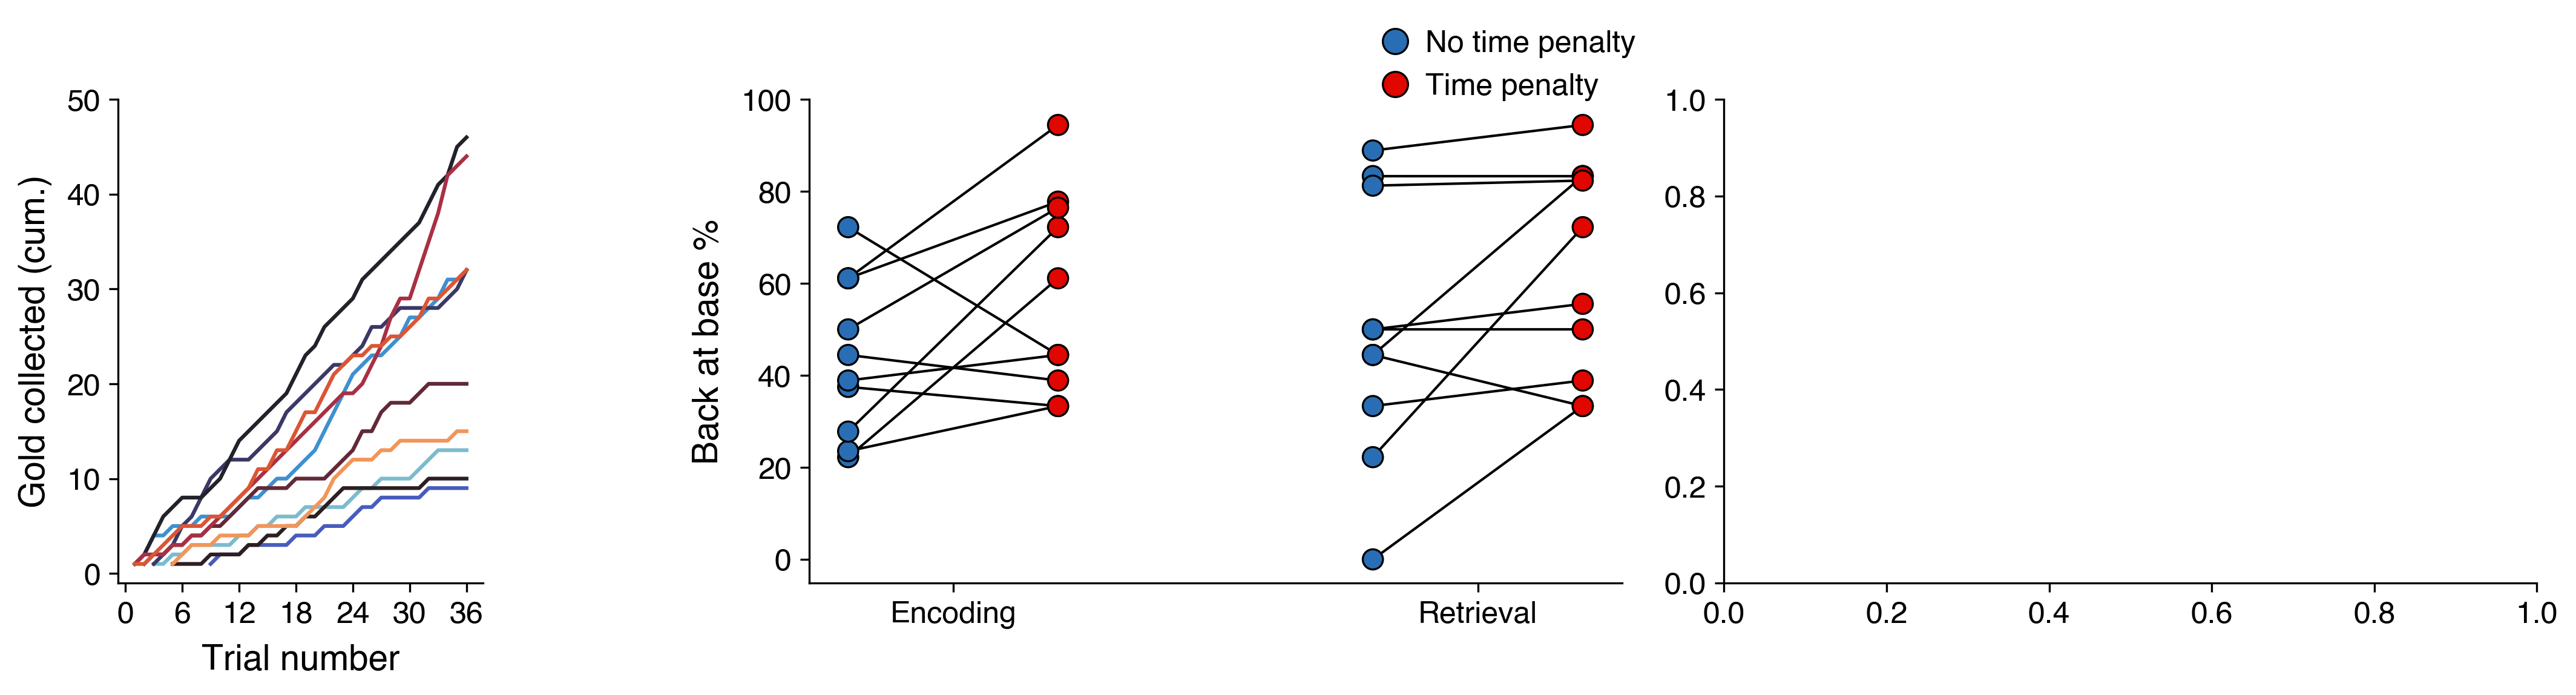

In [60]:
# Plot behavior.
warnings.filterwarnings('ignore')
plt.close()
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
ax = np.ravel(ax)
_colors = ['#296eb4', '#e10600', '#f3a5bf', '#bebebe'] # blue, red, pink, gray

# Plot gold dug by trial.
i = 0
#_cmap = sns.color_palette('Spectral', len(sessions))
_cmap = sns.color_palette('icefire', len(sessions))
# _cmap = sns.color_palette('Paired')
# _cmap = np.array(_cmap)[[0, 1, 2, 4, 6, 8, 9, 10, 11, 12], :]
# _cmap = sns.color_palette(_cmap)
# _cmap[-2] = '#bebebe'
for iLine, subj_sess in enumerate(np.sort(sessions)):
    _events = events[subj_sess]
    n_trials = np.max(_events.trials)
    gold_by_trial = []
    for trial in range(1, n_trials+1):
        gold_by_trial.append([trial, _events.dig_events.query("(dig_success==True)").groupby('trial').size().cumsum().get(trial, np.nan)])
    gold_by_trial = pd.DataFrame(gold_by_trial, columns=['trial', 'gold_dug'])
    gold_by_trial['gold_dug'] = gold_by_trial['gold_dug'].fillna(method='ffill')
    ax[i].plot(gold_by_trial['trial'], gold_by_trial['gold_dug'], linewidth=1.5, color=_cmap[iLine])
    
ax[i].set_xticks(np.arange(0, 37, 6, dtype=np.int))
ax[i].set_xticklabels(np.arange(0, 37, 6, dtype=np.int), 
                      fontsize=font['tick'])
ax[i].set_ylim([-1, 50])
ax[i].set_yticks(np.arange(0, 51, 10, dtype=np.int))
ax[i].set_yticklabels(np.arange(0, 51, 10, dtype=np.int), fontsize=font['tick'])
ax[i].set_xlabel('Trial number', fontsize=font['label'], labelpad=6)
ax[i].set_ylabel('Gold collected (cum.)', fontsize=font['label'], labelpad=6)
ax[i].set_aspect('equal')

# Plot return-to-base percentage.
i = 1
ax[i] = sns.stripplot('gameState', 'at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                      hue_order=[0, 1], jitter=False, dodge=True, palette=_colors, size=8, linewidth=0.8, edgecolor='k')
for ii, game_state in enumerate(['Encoding', 'Retrieval']):
    yvals = [back_at_base.query("(gameState=='{}') & (time_penalty==0)".format(game_state)).sort_values('subj_sess')['at_base'].tolist(),
             back_at_base.query("(gameState=='{}') & (time_penalty==1)".format(game_state)).sort_values('subj_sess')['at_base'].tolist()]
    for iPoint in range(len(yvals[0])):
        ax[i].plot((ii - 0.2, ii + 0.2), (yvals[0][iPoint], yvals[1][iPoint]), 
                   color='k', linewidth=1, zorder=0)
yax = np.arange(0, 101, 20, dtype=np.int)
ax[i].set_yticks(yax)
ax[i].set_yticklabels(yax, fontsize=font['tick'])
ax[i].set_xlabel('')
ax[i].set_ylabel('Back at base %', fontsize=font['label'], labelpad=6)
custom_lines = [Line2D([0], [0], lw=0, marker='o', color='k', label='No time penalty', markerfacecolor=_colors[0], markeredgewidth=0.8, markersize=font['tick']-2),
                Line2D([0], [0], lw=0, marker='o', color='k', label='Time penalty', markerfacecolor=_colors[1], markeredgewidth=0.8, markersize=font['tick']-2)]
legend = ax[i].legend(handles=custom_lines, fontsize=font['tick'], loc=1, bbox_to_anchor=(1.05, 1.2), handletextpad=0)

i = 2
# Plot time spent in each maze location.
# ax[i], maze_map, mask = draw_maze_precise(goldmine_behavior.Maze('SMaze2'),
#                                           traversals,
#                                           scaling_factor=scaling_factor,
#                                           do_convolve=False,
#                                           show_nav=False,
#                                           draw_base=True,
#                                           square=True,
#                                           cmap='rocket',
#                                           cbar_label='No. traversals',
#                                           ax=ax[i])
# ax[i], maze_map, mask = draw_maze(goldmine_behavior.Maze('SMaze2'),
#                                   traversals,
#                                   vmin=0,
#                                   vmax=80,
#                                   draw_base=True,
#                                   square=True,
#                                   cmap='viridis',
#                                   facecolor='#cbced3',
#                                   color_base=colors[1],
#                                   lw_base=1.6,
#                                   cbar_label='No. traversals',
#                                   ax=ax[i])
# cbar = ax[i].collections[0].colorbar
# cbar.ax.tick_params(labelsize=font['tick'])
# cbar_ticks = np.arange(0, 81, 20)
# cbar.set_ticks(cbar_ticks)
# cbar.set_ticklabels(cbar_ticks)
# cbar.set_label('Mean traversals', fontsize=font['annot'], labelpad=6)

fig.tight_layout()
fig.show()
warnings.resetwarnings()

In [83]:
bab = pd.pivot(back_at_base, ['subj_sess', 'gameState'], 'time_penalty', 'at_base').reset_index()
for game_state in ['Encoding', 'Retrieval']:
    _bab = bab.loc[bab['gameState']==game_state]
    print(game_state)
    print('time penalty   : {:.1f} ± {:.1f}%'.format(np.mean(_bab[1]), stats.sem(_bab[1])))
    print('no time penalty: {:.1f} ± {:.1f}%'.format(np.mean(_bab[0]), stats.sem(_bab[0])))
    print(stats.ttest_rel(_bab[1], _bab[0]), 'df = {}'.format(len(_bab)-1), sep='\n', end='\n\n')

Encoding
time penalty   : 57.6 ± 6.8%
no time penalty: 43.9 ± 5.4%
Ttest_relResult(statistic=1.9195509740338925, pvalue=0.0871191334760324)
df = 9

Retrieval
time penalty   : 62.7 ± 7.3%
no time penalty: 49.8 ± 9.0%
Ttest_relResult(statistic=2.0155940901777187, pvalue=0.07465107857268233)
df = 9



In [62]:
digacc = []
for subj_sess in sessions:
    _, df = events[suaj_sess].plot_digging_accuracy(ax=ax[i])
    digacc.append(df)
digacc = np.array(digacc)
digacc[digacc<0] = np.nan
plt.close()

In [45]:
np.nanmean(digacc, axis=1), np.nanmean(digacc)

(array([46.66666667, 63.0952381 , 48.95833333, 79.88505747, 74.95238095,
        62.5       , 54.83870968]), 63.18100358422939)

# Gold find

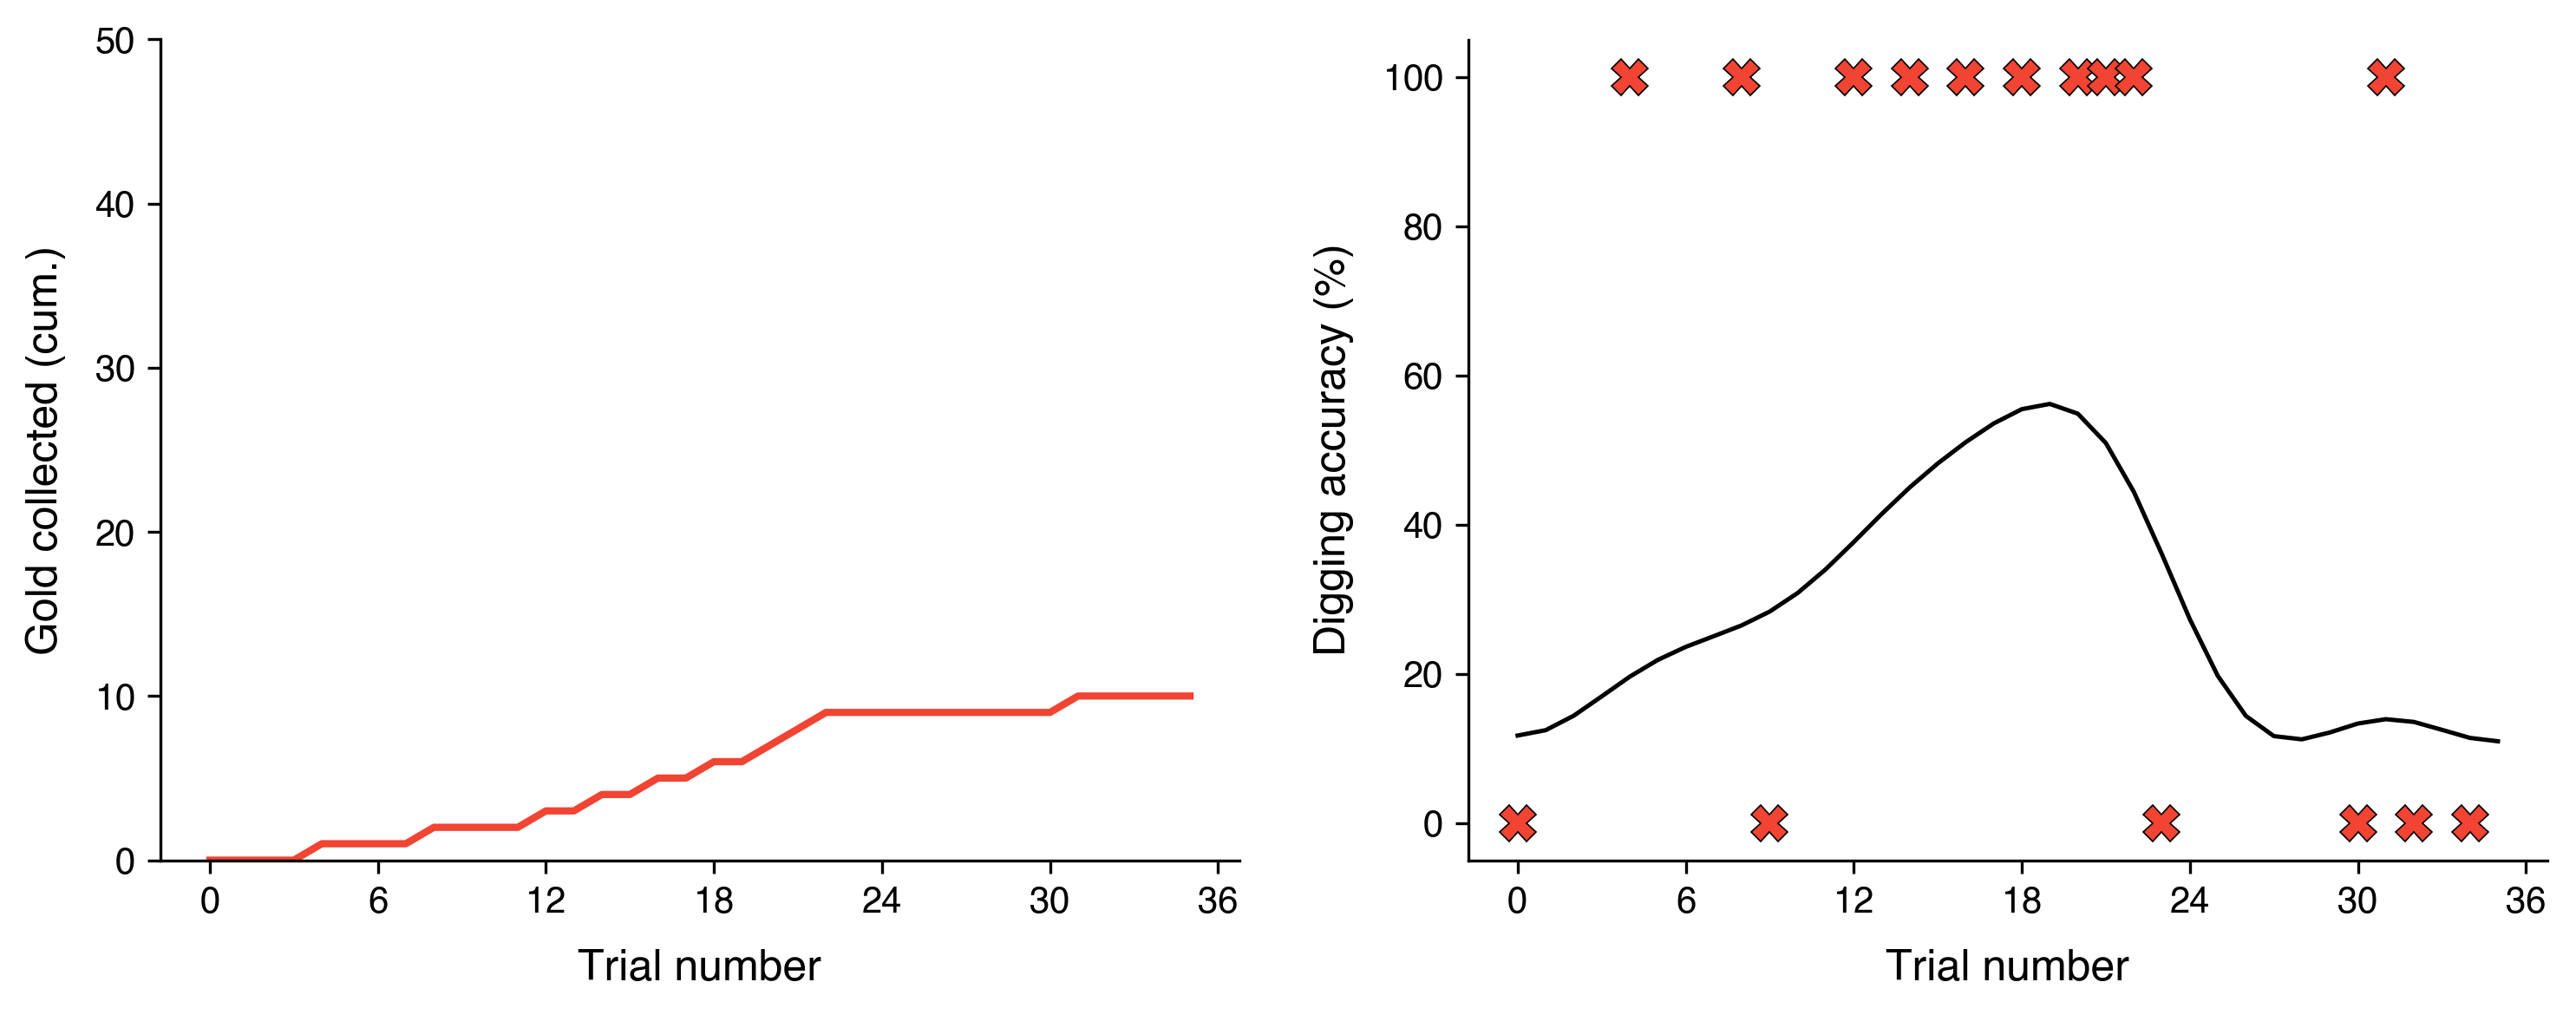

In [6]:
# Plot gold dug and digging accuracy across trials.
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i], _ = events.plot_golds_dug(ax=ax[i], savefig=False)

i = 1
ax[i], _ = events.plot_digging_accuracy(ax=ax[i], savefig=False)

fig.tight_layout(w_pad=2)

In [17]:
# What percent of golds were dug by trial?
cols = ['trial', 'time_penalty', 'gold_spawned', 'gold_dug', 'pct_dug']
digging = []
for idx, df in events.events.groupby('trial'):
    trial = idx
    gold_spawned = df.query("(key=='goldSpawned')")['value'].apply(lambda x: x['nItems']).tolist()[0]
    gold_dug = len(df.query("(key=='dig')")[df.query("(key=='dig')")['value'].apply(lambda x: x['successful'])])
    digging.append([trial, df.iloc[0]['time_penalty'], gold_spawned, gold_dug, (100 * gold_dug)/gold_spawned])
    
digging = pd.DataFrame(digging, columns=cols)  

In [18]:
# How much distance is traveled, and much time spent moving vs. standing still?
cols = ['trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
for idx, df in events.events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['trial', 'gameState']):
    trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

In [21]:
back_at_base = pd.concat([get_back_at_base(events[subj_sess]) for subj_sess in sessions], axis=0)

In [ ]:
['U518_ses0-Encoding',
 'U518_ses0-Retrieval',
 'U521_ses0-Encoding',
 'U521_ses0-Retrieval',
 'U526_ses0-Encoding',
 'U526_ses0-Retrieval',
 'U527_ses0-Encoding',
 'U530_ses0-Encoding',
 'U530_ses0-Retrieval']

[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [65]:
print(stats.ttest_ind(back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Encoding') & (time_penalty==1)")['at_base'].tolist(),
                      back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Encoding') & (time_penalty==0)")['at_base'].tolist()))
print(stats.ttest_ind(back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Retrieval') & (time_penalty==1)")['at_base'].tolist(),
                      back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Retrieval') & (time_penalty==0)")['at_base'].tolist()))

Ttest_indResult(statistic=2.8929622827183157, pvalue=0.006614012706795739)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [59]:
grp = back_at_base.groupby('subj_sess')
for subj_sess, back_at_base_ in grp:
    print(subj_sess, '\n')
    for game_state in ['Encoding', 'Retrieval']:
        print('{}: {:.2f}'.format(game_state,
                                  back_at_base_.query("(gameState=='{}') & (time_penalty==1)".format(game_state))['at_base'].mean() - 
                                  back_at_base_.query("(gameState=='{}') & (time_penalty==0)".format(game_state))['at_base'].mean()))
    print('\n')
    
    mod = ols('at_base ~ C(gameState) * C(time_penalty)', back_at_base_).fit()
    print(mod.summary())
    #print(mod.get_margeff().summary())
    
    print('\n')
    
    mod = ols('at_base ~ C(gameState) + C(time_penalty)', back_at_base_).fit()
    print(mod.summary())
    #print(mod.get_margeff().summary())

    print('\n\n\n')

U518_ses0 

Encoding: 0.39
Retrieval: 0.50


                            OLS Regression Results                            
Dep. Variable:                at_base   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     5.890
Date:                Mon, 11 Jan 2021   Prob (F-statistic):            0.00123
Time:                        14:01:01   Log-Likelihood:                -43.494
No. Observations:                  72   AIC:                             94.99
Df Residuals:                      68   BIC:                             104.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

U518_ses0
Encoding: 0.39
Retrieval: 0.50
Optimization terminated successfully.
         Current function value: 0.579626
         Iterations 5
        Logit Marginal Effects       
Dep. Variable:                at_base
Method:                          dydx
At:                           overall
                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
C(gameState)[T.Retrieval]                        4.62e-18      0.157   2.94e-17      1.000      -0.308       0.308
C(time_penalty)[T.1]                               0.3341      0.125      2.666      0.008       0.089       0.580
C(gameState)[T.Retrieval]:C(time_penalty)[T.1]     0.0987      0.209      0.471      0.637      -0.312       0.509
Optimization terminated successfully.
         Current function value: 0.579626
         Iterations 5
        Logit Marginal Effec

In [28]:
model = ols('at_base ~ C(gameState) * C(time_penalty)', back_at_base_).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')
model = ols('at_base ~ C(gameState) + C(time_penalty)', back_at_base_).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Overall model F(3,68) = 5.89, p = 0.0012

                                 sum_sq    df          F    PR(>F)
C(gameState)                   0.055556   1.0   0.267717  0.606547
C(time_penalty)                3.555556   1.0  17.133858  0.000098
C(gameState):C(time_penalty)   0.055556   1.0   0.267717  0.606547
Residual                      14.111111  68.0        NaN       NaN

Minus the interaction
---------------------
Overall model F(2,69) = 8.79, p = 0.0004

                    sum_sq    df          F    PR(>F)
C(gameState)      0.055556   1.0   0.270588  0.604603
C(time_penalty)   3.555556   1.0  17.317647  0.000090
Residual         14.166667  69.0        NaN       NaN



In [20]:
stats.ttest_ind(digging.query("(time_penalty==1)")['pct_dug'],
                digging.query("(time_penalty==0)")['pct_dug'])

Ttest_indResult(statistic=0.563992303216381, pvalue=0.5764610325665552)

In [21]:
model = ols('dist_trav ~ C(gameState) * C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')

model = ols('dist_trav ~ C(gameState) + C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Overall model F(3,68) = 0.26, p = 0.8537

                                    sum_sq    df         F    PR(>F)
C(gameState)                     20.715139   1.0  0.052568  0.819342
C(time_penalty)                 275.304271   1.0  0.698629  0.406172
C(gameState):C(time_penalty)     11.722056   1.0  0.029747  0.863579
Residual                      26796.342661  68.0       NaN       NaN

Minus the interaction
---------------------
Overall model F(2,69) = 0.38, p = 0.6846

                       sum_sq    df         F    PR(>F)
C(gameState)        20.715139   1.0  0.053318  0.818071
C(time_penalty)    275.304271   1.0  0.708593  0.402820
Residual         26808.064717  69.0       NaN       NaN



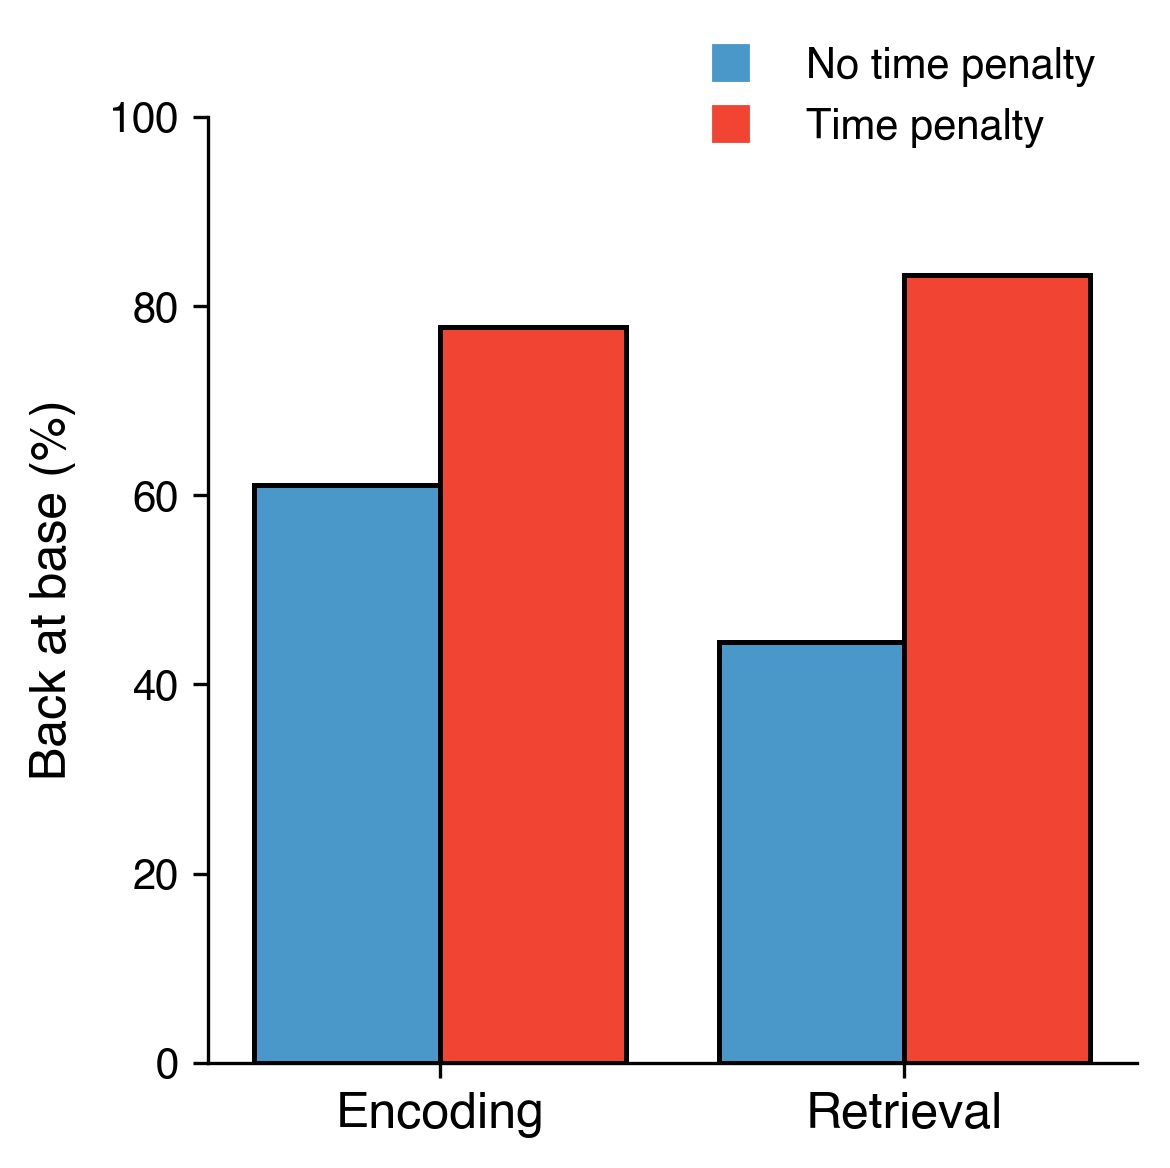

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2
font = events.plot_params['font']

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.linspace(0, 100, 6))
ax[i].set_yticklabels(np.linspace(0, 100, 6, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.95))

fig.tight_layout()

if True:
    fig.savefig('/home1/dscho/projects/time_cells/figs/{}-behavior-back_at_base.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

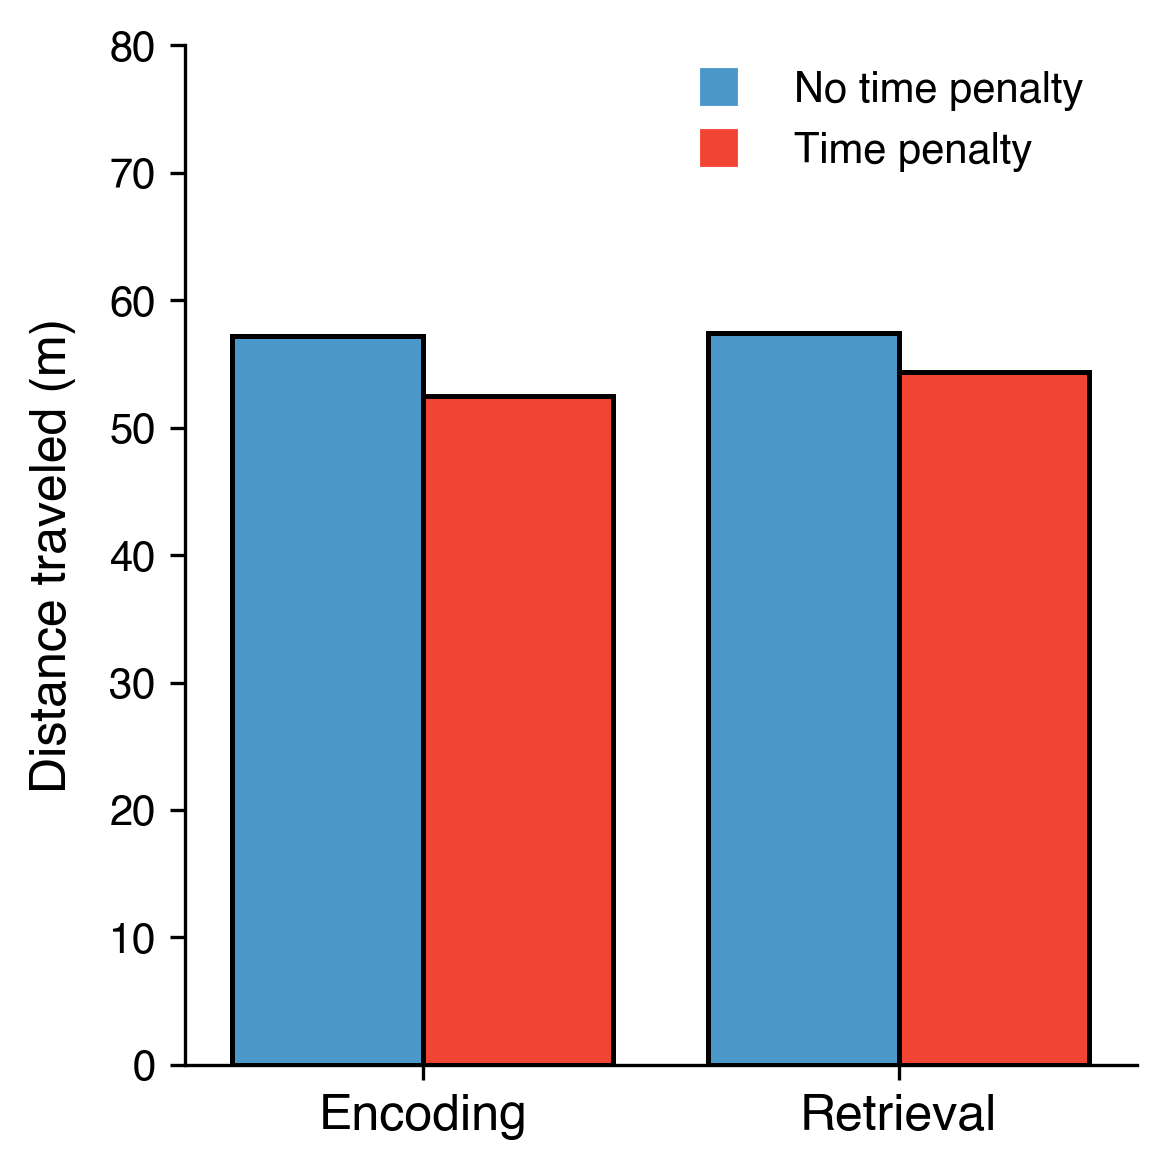

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='dist_trav', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Distance traveled (m)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.86))

fig.tight_layout()

if True:
    fig.savefig('/home1/dscho/projects/time_cells/figs/{}-behavior-distance_traveled.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

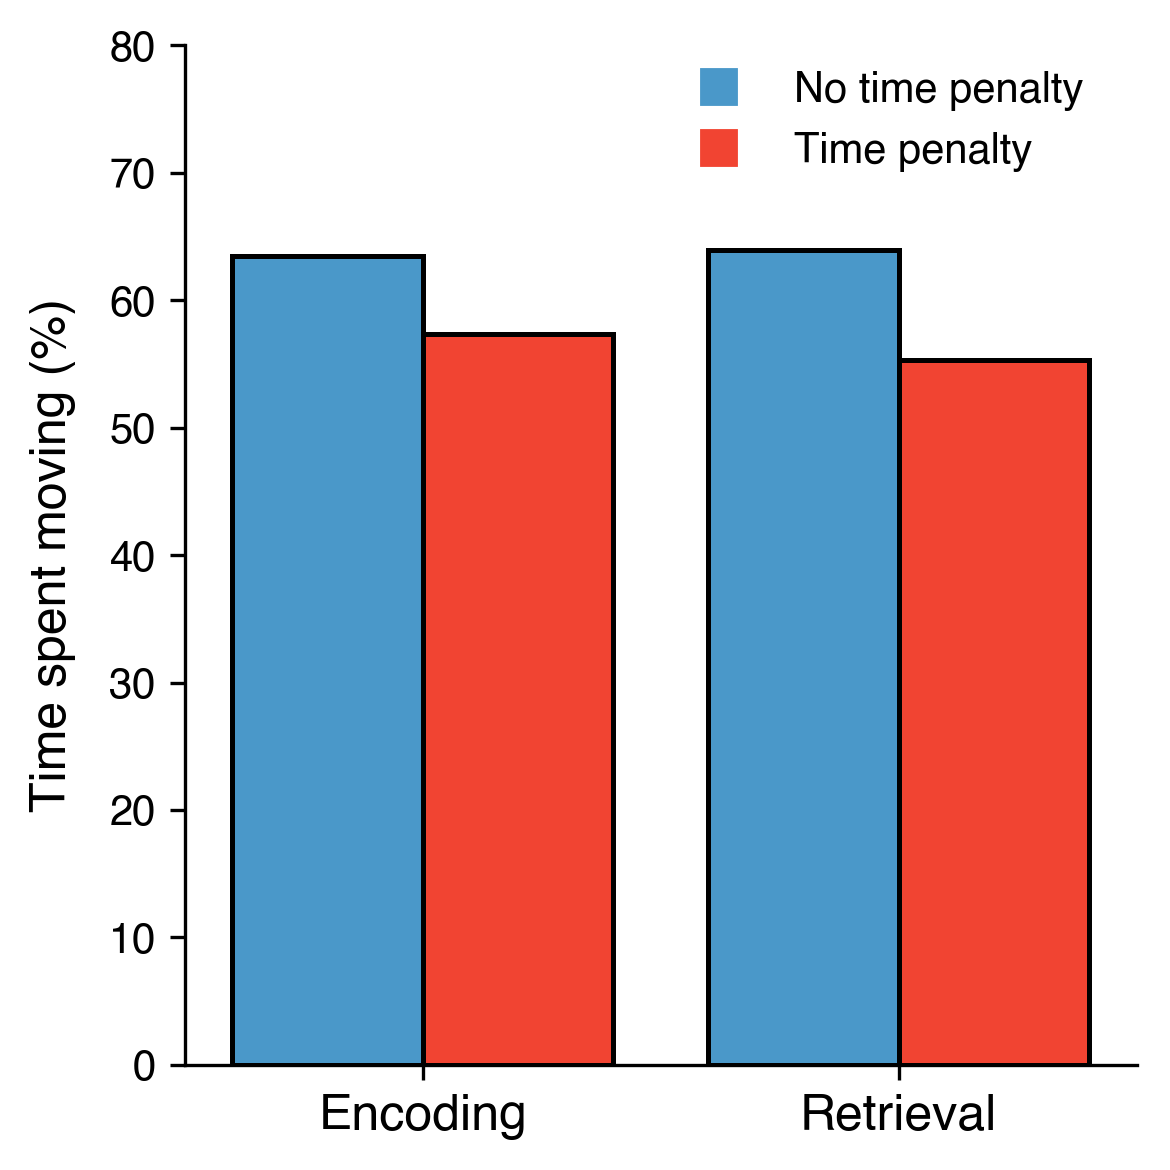

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='pct_moving', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time spent moving (%)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.86))

fig.tight_layout()

if True:
    fig.savefig('/home1/dscho/projects/time_cells/figs/{}-behavior-time_moving.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

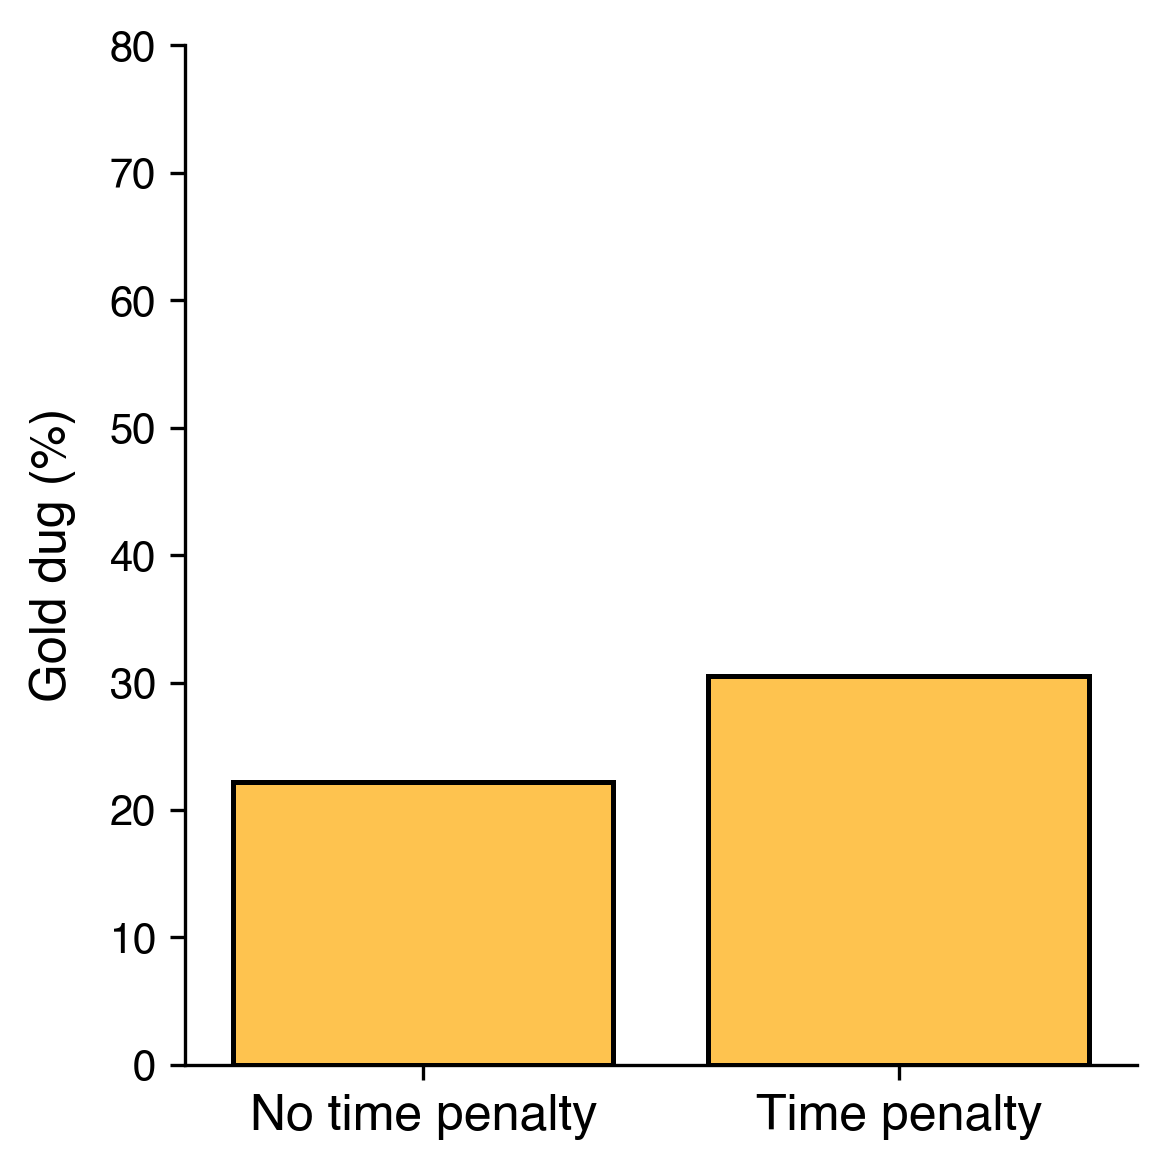

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='time_penalty', y='pct_dug', data=digging, ax=ax[i],
                    ci=None, color=colors[6], saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['No time penalty', 'Time penalty'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Gold dug (%)', fontsize=font['label'], labelpad=8)

fig.tight_layout()

if True:
    fig.savefig('/home1/dscho/projects/time_cells/figs/{}-behavior-gold_dug.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

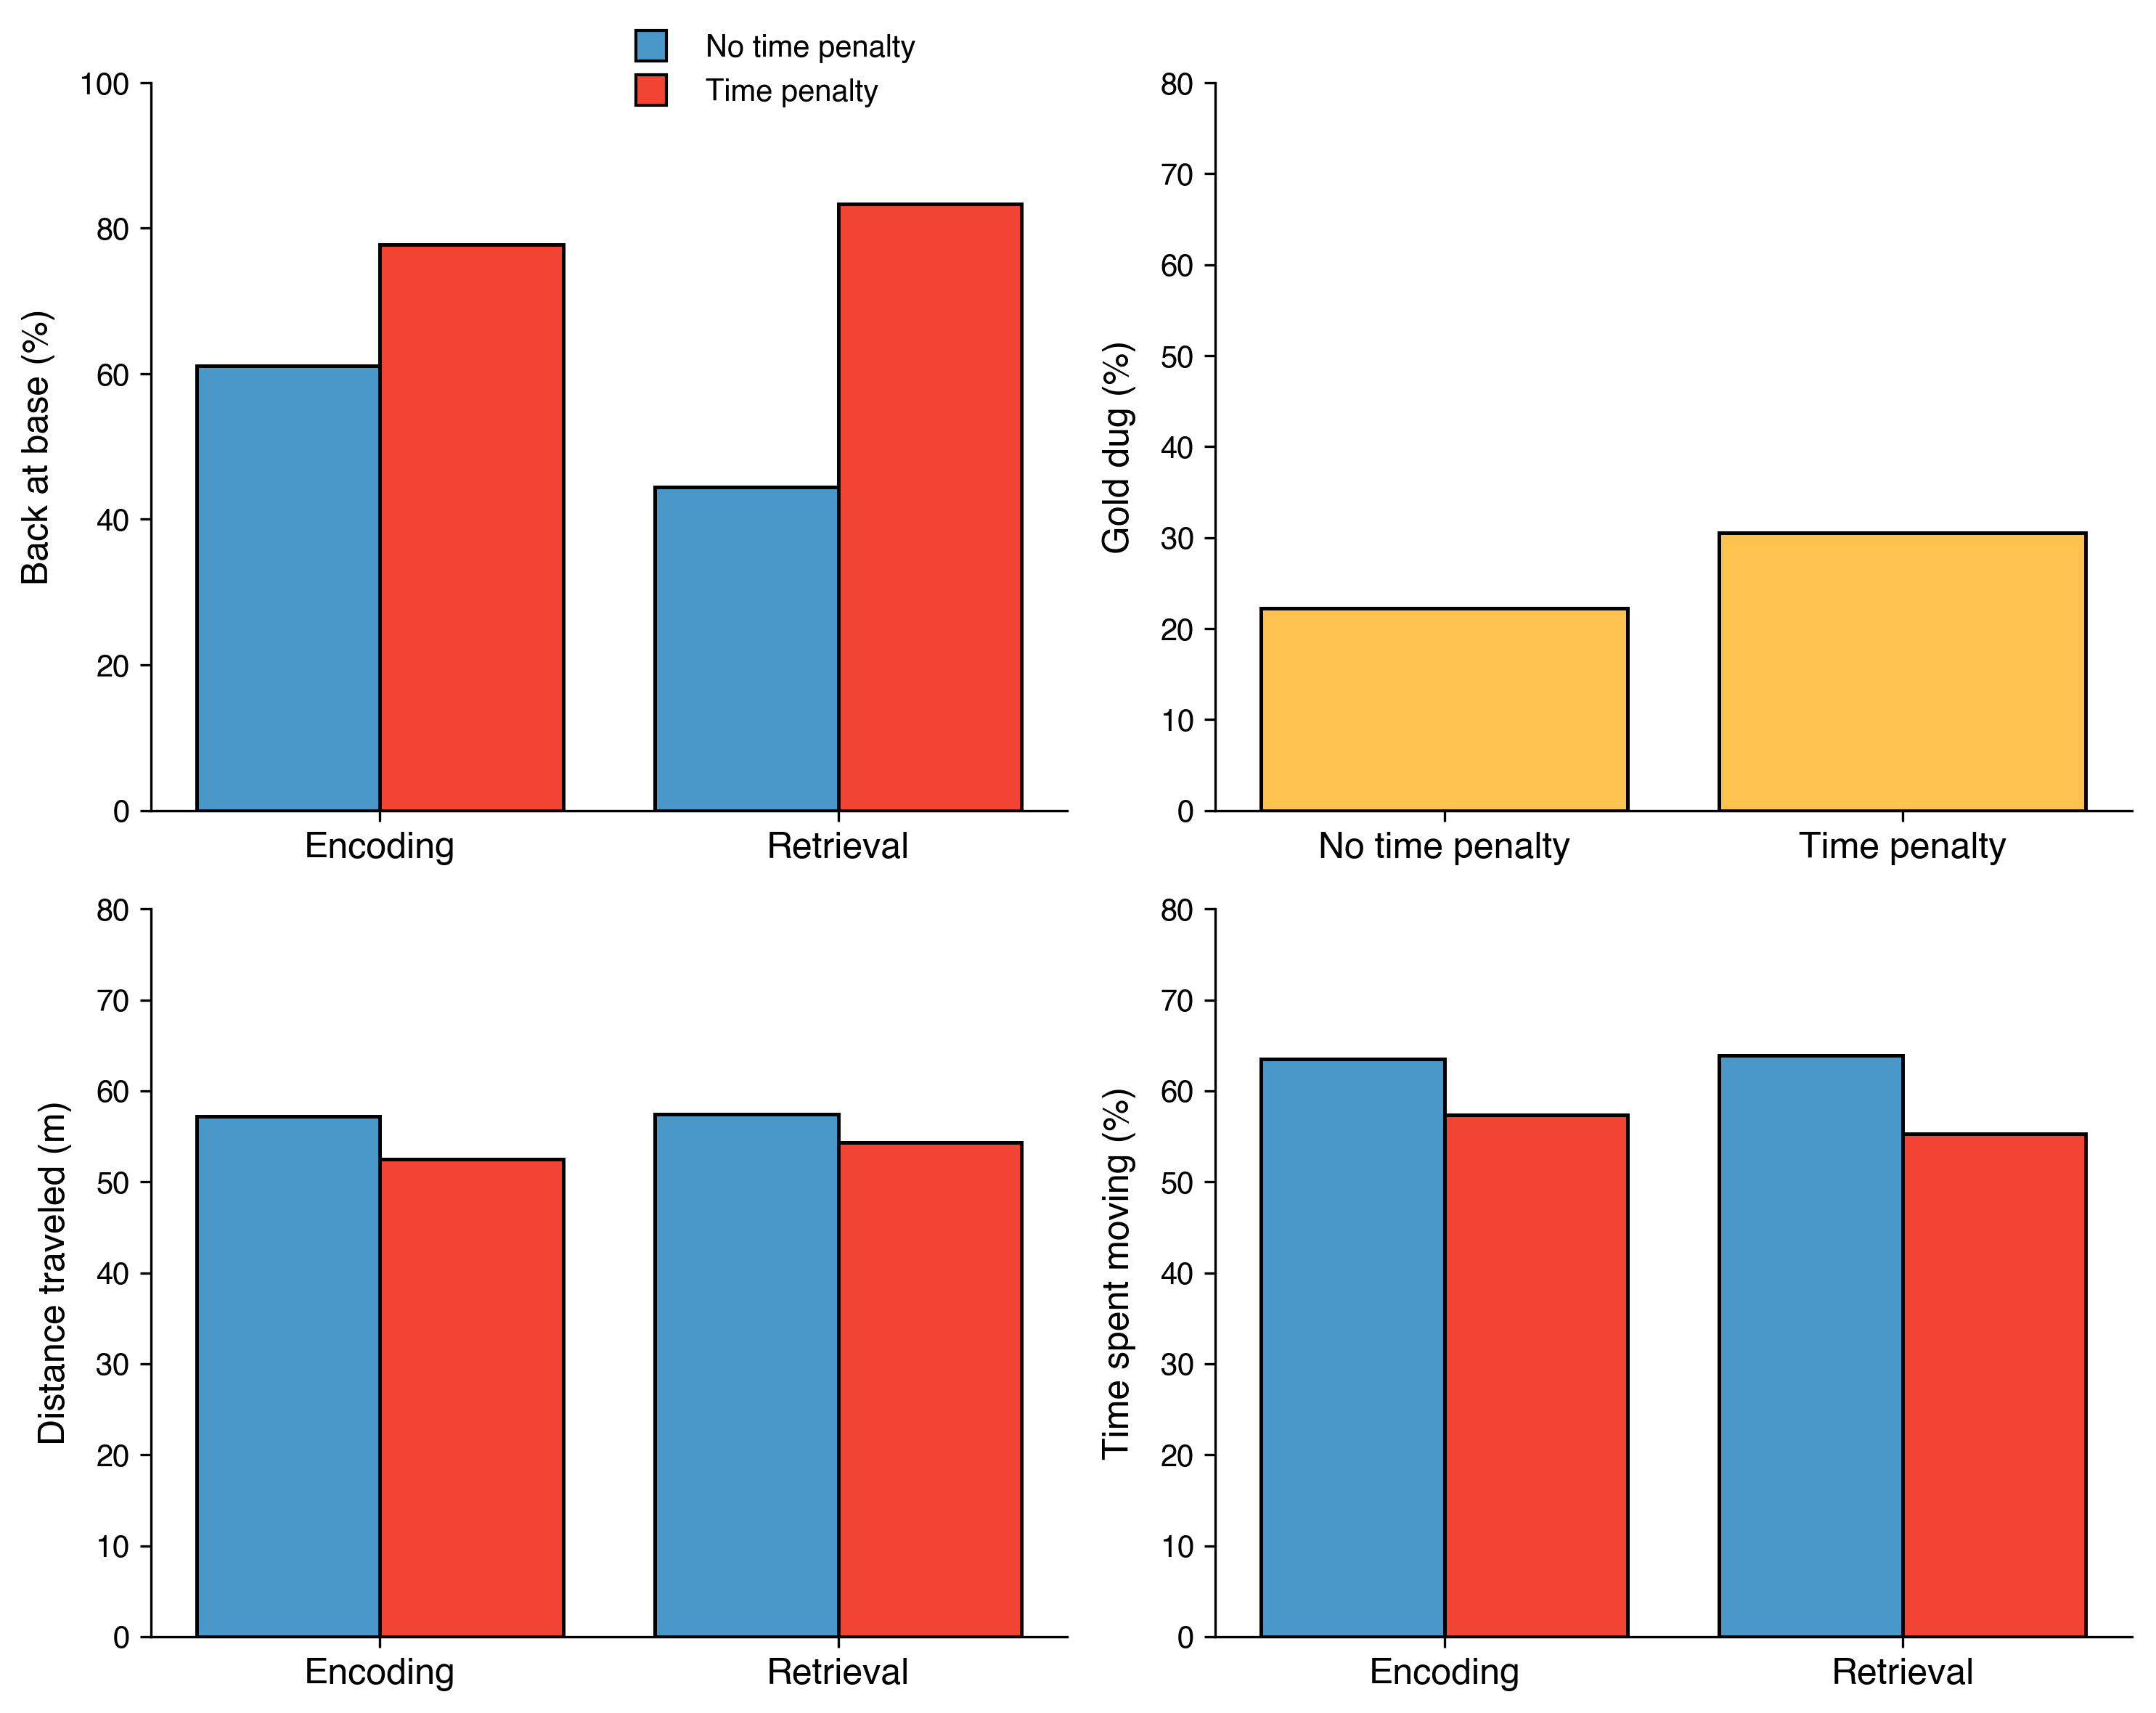

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.linspace(0, 100, 6))
ax[i].set_yticklabels(np.linspace(0, 100, 6, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=font['label'], labelpad=8)

i = 1
ax[i] = sns.barplot(x='time_penalty', y='pct_dug', data=digging, ax=ax[i],
                    ci=None, color=colors[6], saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['No time penalty', 'Time penalty'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Gold dug (%)', fontsize=font['label'], labelpad=8)

i = 2
ax[i] = sns.barplot(x='gameState', y='dist_trav', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Distance traveled (m)', fontsize=font['label'], labelpad=8)
ax[i].get_legend().remove()

i = 3
ax[i] = sns.barplot(x='gameState', y='pct_moving', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time spent moving (%)', fontsize=font['label'], labelpad=8)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick'], linewidth=0.6, markeredgecolor='k'),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'], linewidth=0.6, markeredgecolor='k')]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.95))

fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/{}_behav2.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

# Subject location and movement

In [668]:
# Calculate the duration (s) between consecutive position measurements.
pos_dur = np.median(events.positions.groupby(['trial', 'gameState'])['time'].apply(lambda x: np.median(np.diff(x)))) * 1e-3

# How much time did the player spend at each location?
counts = (events.positions['maze_idx'].value_counts() * pos_dur).to_dict()

maze_vals = counts.copy()

In [104]:
for hd in ['N', 'S', 'E', 'W']:
    print(hd, events.pos_intervals.query("(gameState=='Encoding') & (head_direc=='{}')".format(hd))['maze_idx'].value_counts().sum())

N 292
S 236
E 265
W 288


In [5]:
# Load spike files.
files = np.sort(glob(os.path.join(proj_dir, 'analysis', 'spikes', '{}*unit*.pkl'.format(subj_sess))))
print('{} files'.format(len(files)))

for f in files[:1]:
    neuron = dio.open_pickle(f)

33 files


In [376]:
events = goldmine_behavior.Events(subj_sess)
events.log_position_intervals(idx_on='moved_pos')
events.pos_intervals['pos'] = events.pos_intervals['pos'].apply(lambda x: (int(x[0]), int(x[1])))

In [246]:
game_state = 'Encoding'
iUnit = 18
scaling_factor = 1

neuron = dio.open_pickle(files[iUnit])
event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
event_times_['spike_train'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0))
spike_train_vec = np.concatenate(event_times_['spike_train'].tolist())
event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
fr_vec = np.concatenate(event_times_['fr'].tolist())

positions_ = events.positions.query("(gameState=='{}')".format(game_state)).copy()
all_pos = od([])
# all_fr = od([])
for trial, df in positions_.groupby('trial'):
#     all_pos[trial] = np.array(df['pos'].tolist()) * scaling_factor
    fr_arr = np.expand_dims(pd.merge(df[['gameState', 'trial', 'time', 'pos']], event_times_[['gameState', 'trial', 'time', 'fr']], 
                                     how='left', on=['gameState', 'trial']).apply(lambda x: x['fr'][x['time_x'] - x['time_y'][0]], axis=1),
                            axis=-1)
    all_pos[trial] = np.concatenate((np.array(df['pos'].tolist()) * scaling_factor, fr_arr), axis=-1)
    
positions_['pos'] = positions_['pos'].apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
idx_to_pos = positions_['pos'].value_counts().reset_index()['index'].to_dict()
pos_to_idx = {v:k for k, v in idx_to_pos.items()}
pos_vec = np.concatenate(positions_.apply(lambda x: pos_to_idx[x['pos']] * np.ones(x['dur']), axis=1).tolist())
assert len(pos_vec) == len(fr_vec)
dur_by_pos = {idx_to_pos[idx]:len(np.where(pos_vec==idx)[0]) for idx in idx_to_pos.keys()}
trav_by_pos = events.pos_intervals.query("(gameState=='{}')".format(game_state))['pos'].apply(lambda x: (x[0]*scaling_factor, x[1]*scaling_factor)).value_counts().to_dict()
fr_by_pos = {idx_to_pos[idx]:np.mean(fr_vec[np.where(pos_vec==idx)[0]]) for idx in idx_to_pos.keys()}

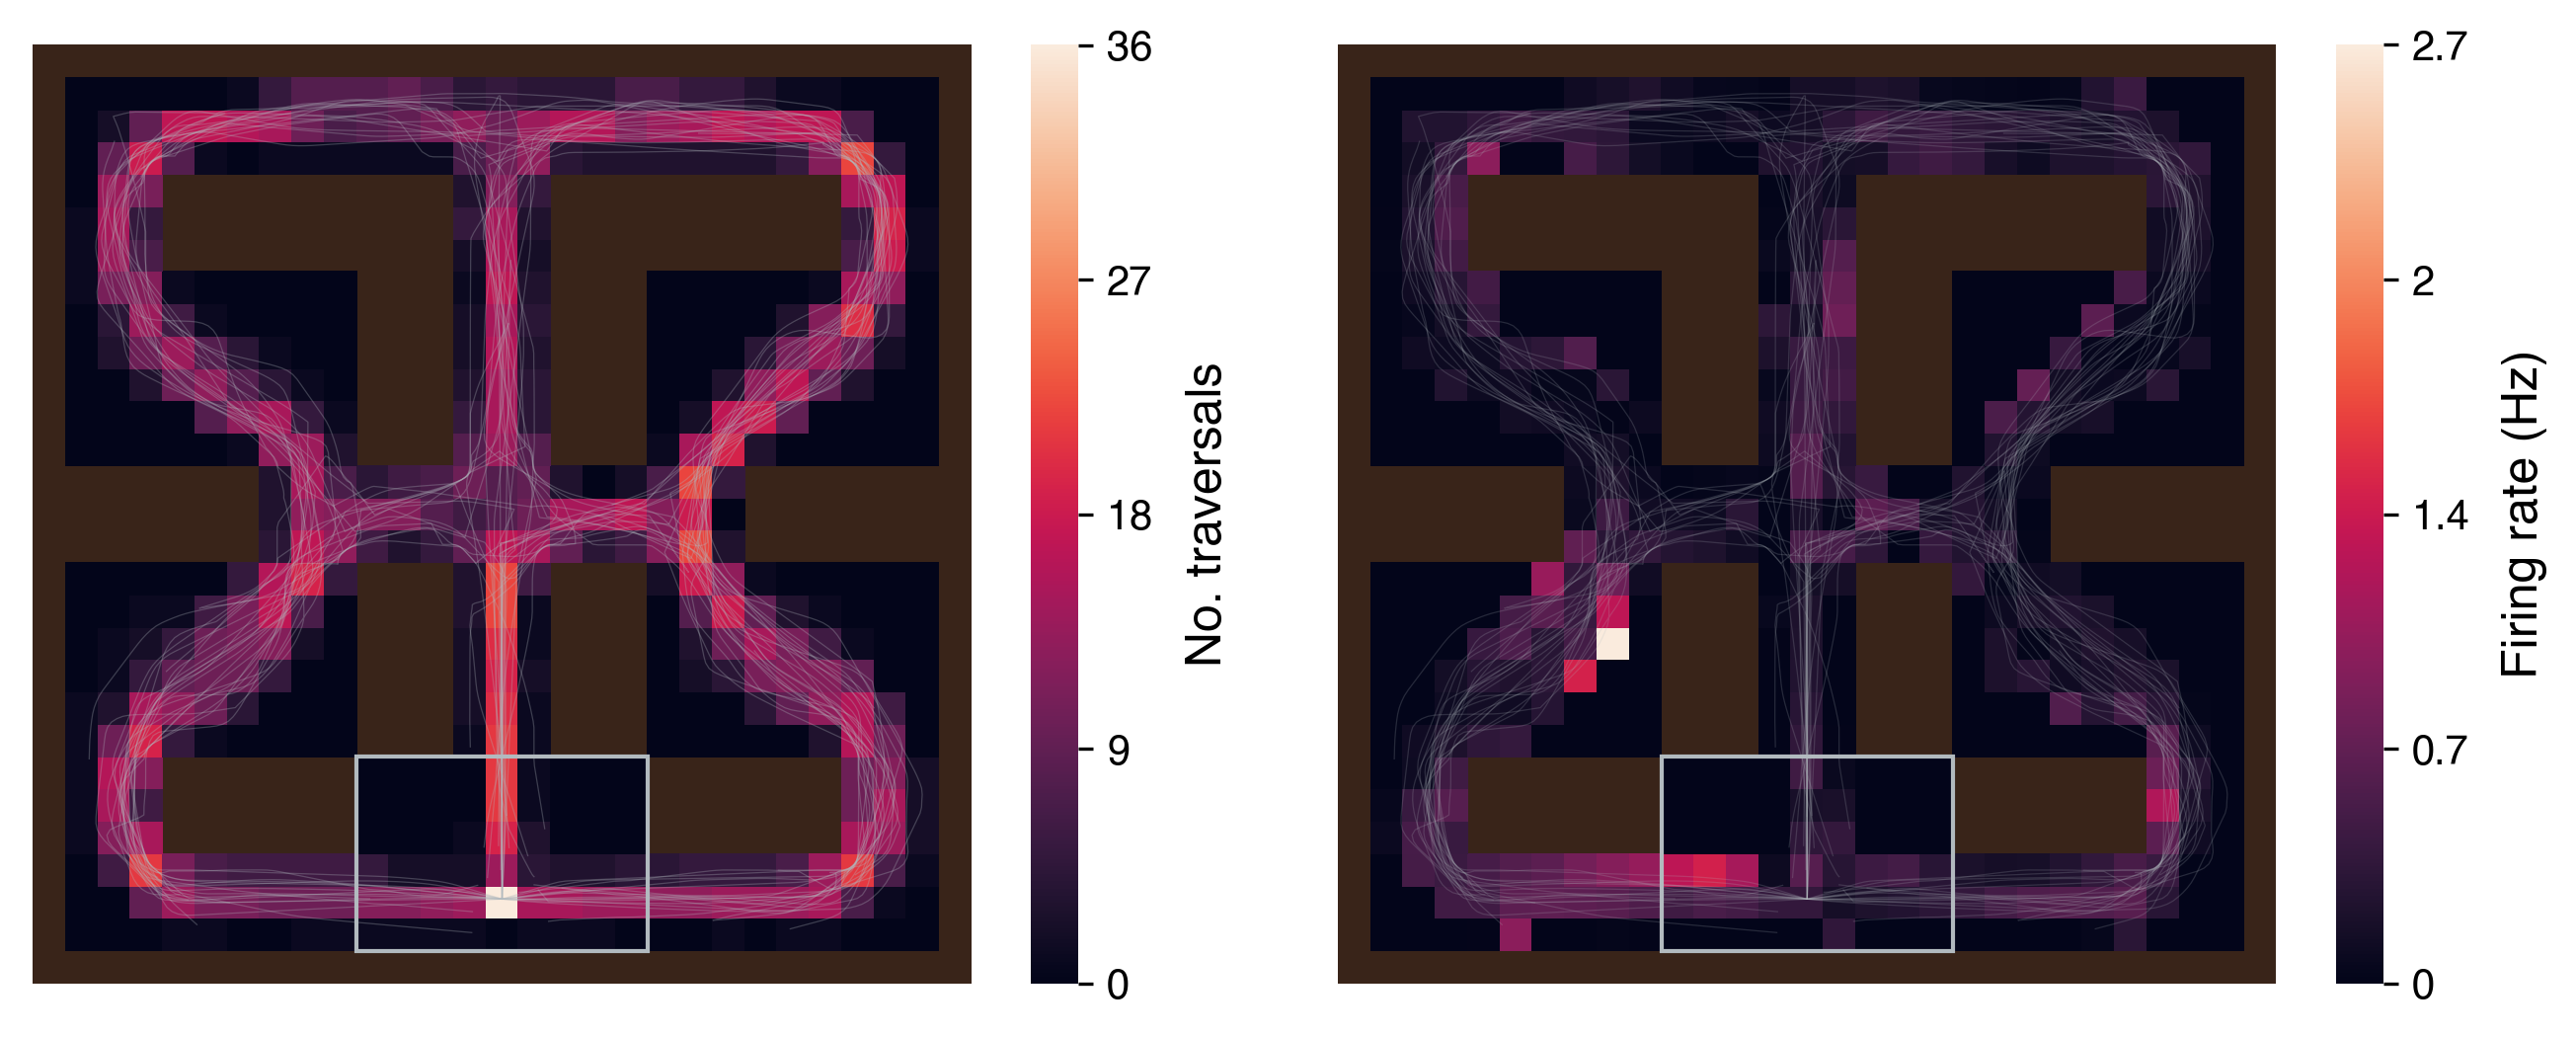

In [247]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i], maze_map, mask = draw_maze_precise(events,
                                          trav_by_pos,
                                          scaling_factor=scaling_factor,
                                          do_convolve=False,
                                          all_pos=all_pos,
                                          show_nav=True,
                                          draw_base=True,
                                          square=True,
                                          cmap='rocket',
                                          cbar_label='No. traversals',
                                          ax=ax[i])

i = 1
ax[i], maze_map, mask = draw_maze_precise(events,
                                          fr_by_pos,
                                          scaling_factor=scaling_factor,
                                          do_convolve=False,
                                          all_pos=all_pos,
                                          show_nav=True,
                                          draw_base=True,
                                          square=True,
                                          cmap='rocket',
                                          alpha_nav=0.2,
                                          cbar_label='Firing rate (Hz)',
                                          ax=ax[i])

fig.tight_layout()

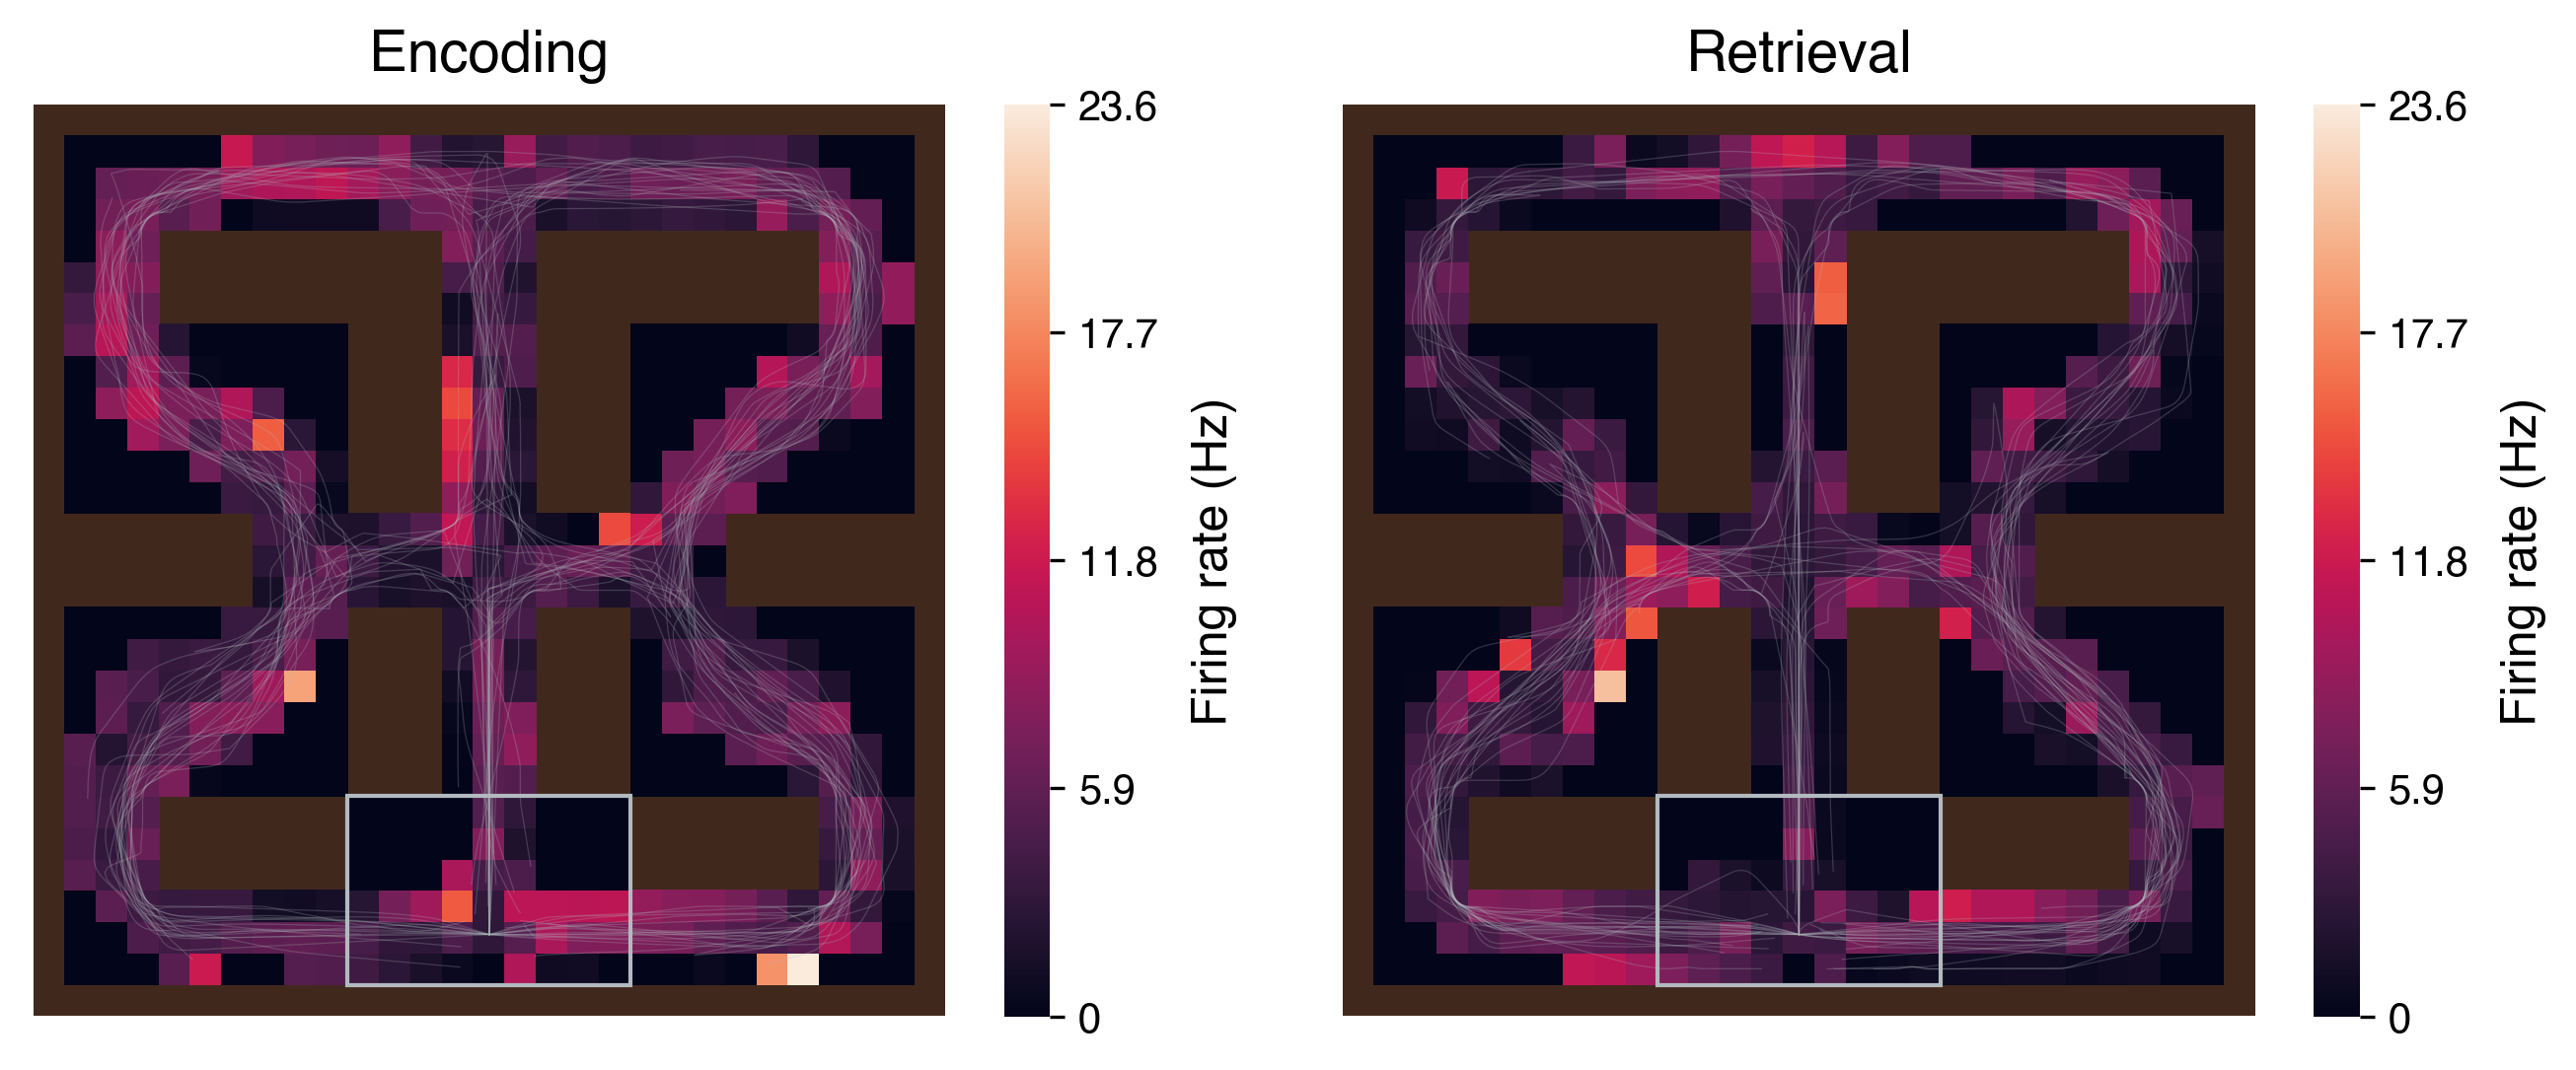

In [331]:
iUnit = 31
scaling_factor = 1

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)
neuron = dio.open_pickle(files[iUnit])
all_pos = od([])
fr_by_pos = od([])
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
    event_times_['spike_train'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0))
    spike_train_vec = np.concatenate(event_times_['spike_train'].tolist())
    event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
    fr_vec = np.concatenate(event_times_['fr'].tolist())

    positions_ = events.positions.query("(gameState=='{}')".format(game_state)).copy()
    all_pos[game_state] = od([])
    for trial, df in positions_.groupby('trial'):
        fr_arr = np.expand_dims(pd.merge(df[['gameState', 'trial', 'time', 'pos']], event_times_[['gameState', 'trial', 'time', 'fr']], 
                                         how='left', on=['gameState', 'trial']).apply(lambda x: x['fr'][x['time_x'] - x['time_y'][0]], axis=1),
                                axis=-1)
        all_pos[game_state][trial] = np.concatenate((np.array(df['pos'].tolist()) * scaling_factor, fr_arr), axis=-1)

    positions_['pos'] = positions_['pos'].apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
    idx_to_pos = positions_['pos'].value_counts().reset_index()['index'].to_dict()
    pos_to_idx = {v:k for k, v in idx_to_pos.items()}
    pos_vec = np.concatenate(positions_.apply(lambda x: pos_to_idx[x['pos']] * np.ones(x['dur']), axis=1).tolist())
    assert len(pos_vec) == len(fr_vec)
    dur_by_pos = {idx_to_pos[idx]:len(np.where(pos_vec==idx)[0]) for idx in idx_to_pos.keys()}
    trav_by_pos = events.pos_intervals.query("(gameState=='{}')".format(game_state))['pos'].apply(lambda x: (x[0]*scaling_factor, x[1]*scaling_factor)).value_counts().to_dict()
    fr_by_pos[game_state] = {idx_to_pos[idx]:np.mean(fr_vec[np.where(pos_vec==idx)[0]]) for idx in idx_to_pos.keys()}
    
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))
    
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    ax[i], maze_map, mask = draw_maze_precise(events,
                                              fr_by_pos[game_state],
                                              all_pos=all_pos[game_state],
                                              vmin=vmin,
                                              vmax=vmax,
                                              scaling_factor=scaling_factor,
                                              do_convolve=False,
                                              show_nav=True,
                                              draw_base=True,
                                              square=True,
                                              cmap='rocket',
                                              alpha_nav=0.25,
                                              cbar_label='Firing rate (Hz)',
                                              ax=ax[i])
    ax[i].set_title(game_state, fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

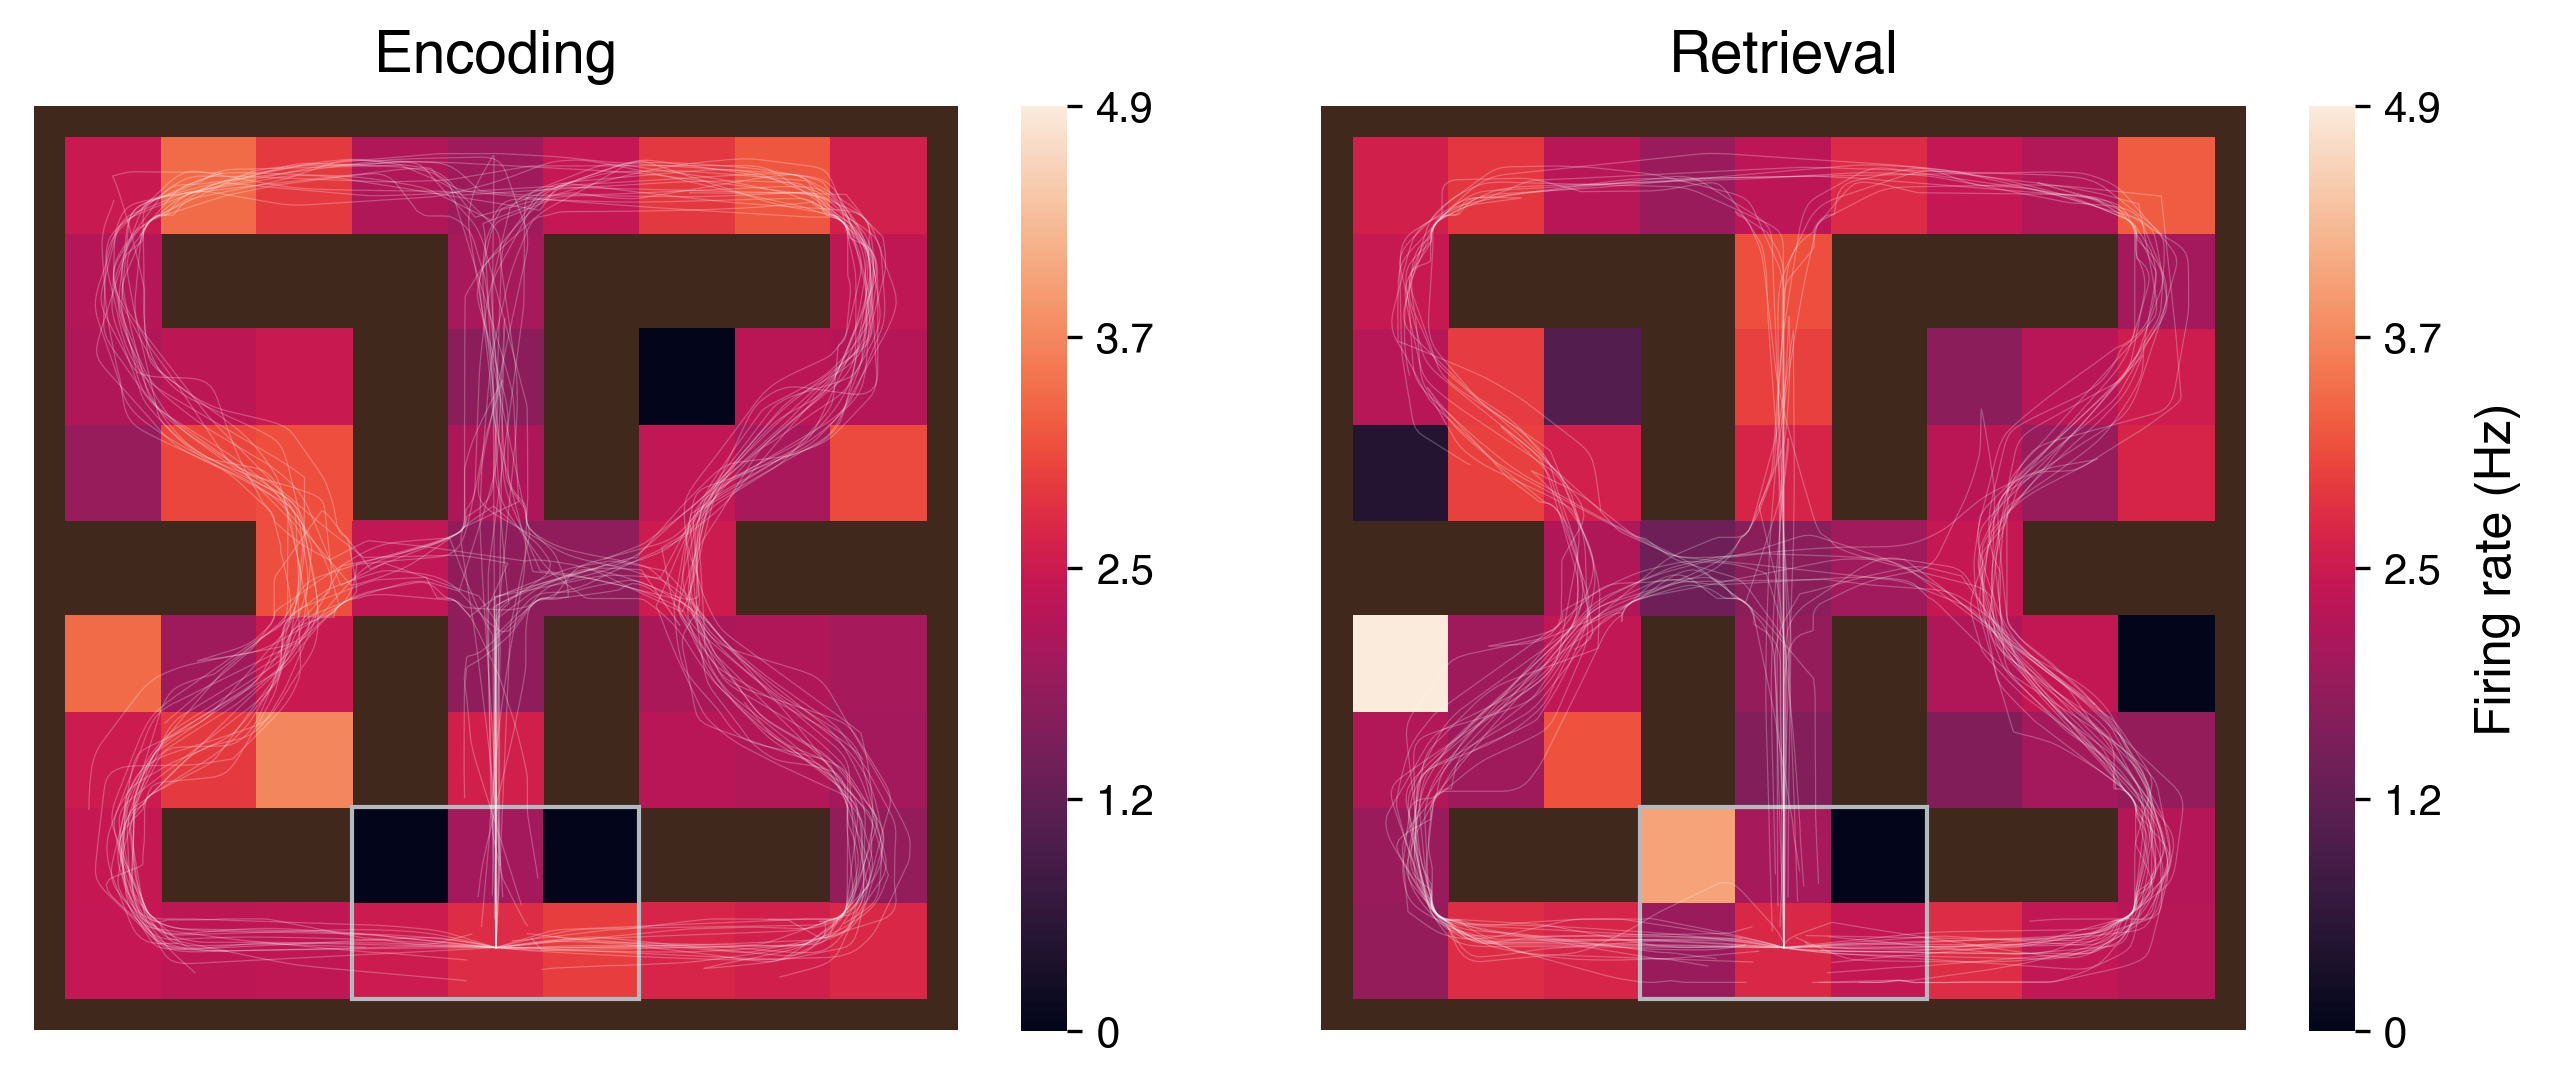

In [378]:
on = 'maze_idx'
min_traversals = 0
iUnit = 32

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)
neuron = dio.open_pickle(files[iUnit])
fr_by_pos = od([])
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
    event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
    fr_vec = np.concatenate(event_times_['fr'].tolist())
    pos_intervals_ = events.pos_intervals.query("(gameState=='{}')".format(game_state))
    pos_keys = list(pos_intervals_[on].unique())
    pos_vec = np.concatenate(pos_intervals_.apply(lambda x: x[on] * np.ones(x['dur']), axis=1).tolist())
    assert len(fr_vec) == len(pos_vec)
    pos_durs = {k: len(np.where(pos_vec==k)[0]) for k in pos_keys}
    pos_traversals = {k:pos_intervals_.groupby('maze_idx').size().to_dict().get(k, 0)
                      for k in events.maze.maze.query("(region!='wall')").index.tolist()}
    fr_by_pos[game_state] = {k: np.mean(fr_vec[np.where(pos_vec==k)[0]])
                             for k in pos_keys
                             if (pos_traversals.get(k, 0)>=min_traversals)}
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))

for i, game_state in enumerate(['Encoding', 'Retrieval']):
    if i == len(ax) - 1:
        cbar_label = 'Firing rate (Hz)'
    else:
        cbar_label = ''
    ax[i], *_ = events.draw_maze(fr_by_pos[game_state],
                                 vmin=vmin,
                                 vmax=vmax,
                                 cmap='rocket',
                                 square=True,
                                 show_nav=True,
                                 game_state=game_state,
                                 color_nav='w',
                                 cbar_label=cbar_label,
                                 ax=ax[i])
    ax[i].set_title(game_state, fontsize=events.plot_params['font']['fig'], pad=8)
    
fig.tight_layout()

Found /home1/dscho/projects/time_cells/analysis/fr_by_pos/U527_ses0-CSC45-unit2-event_fr.pkl


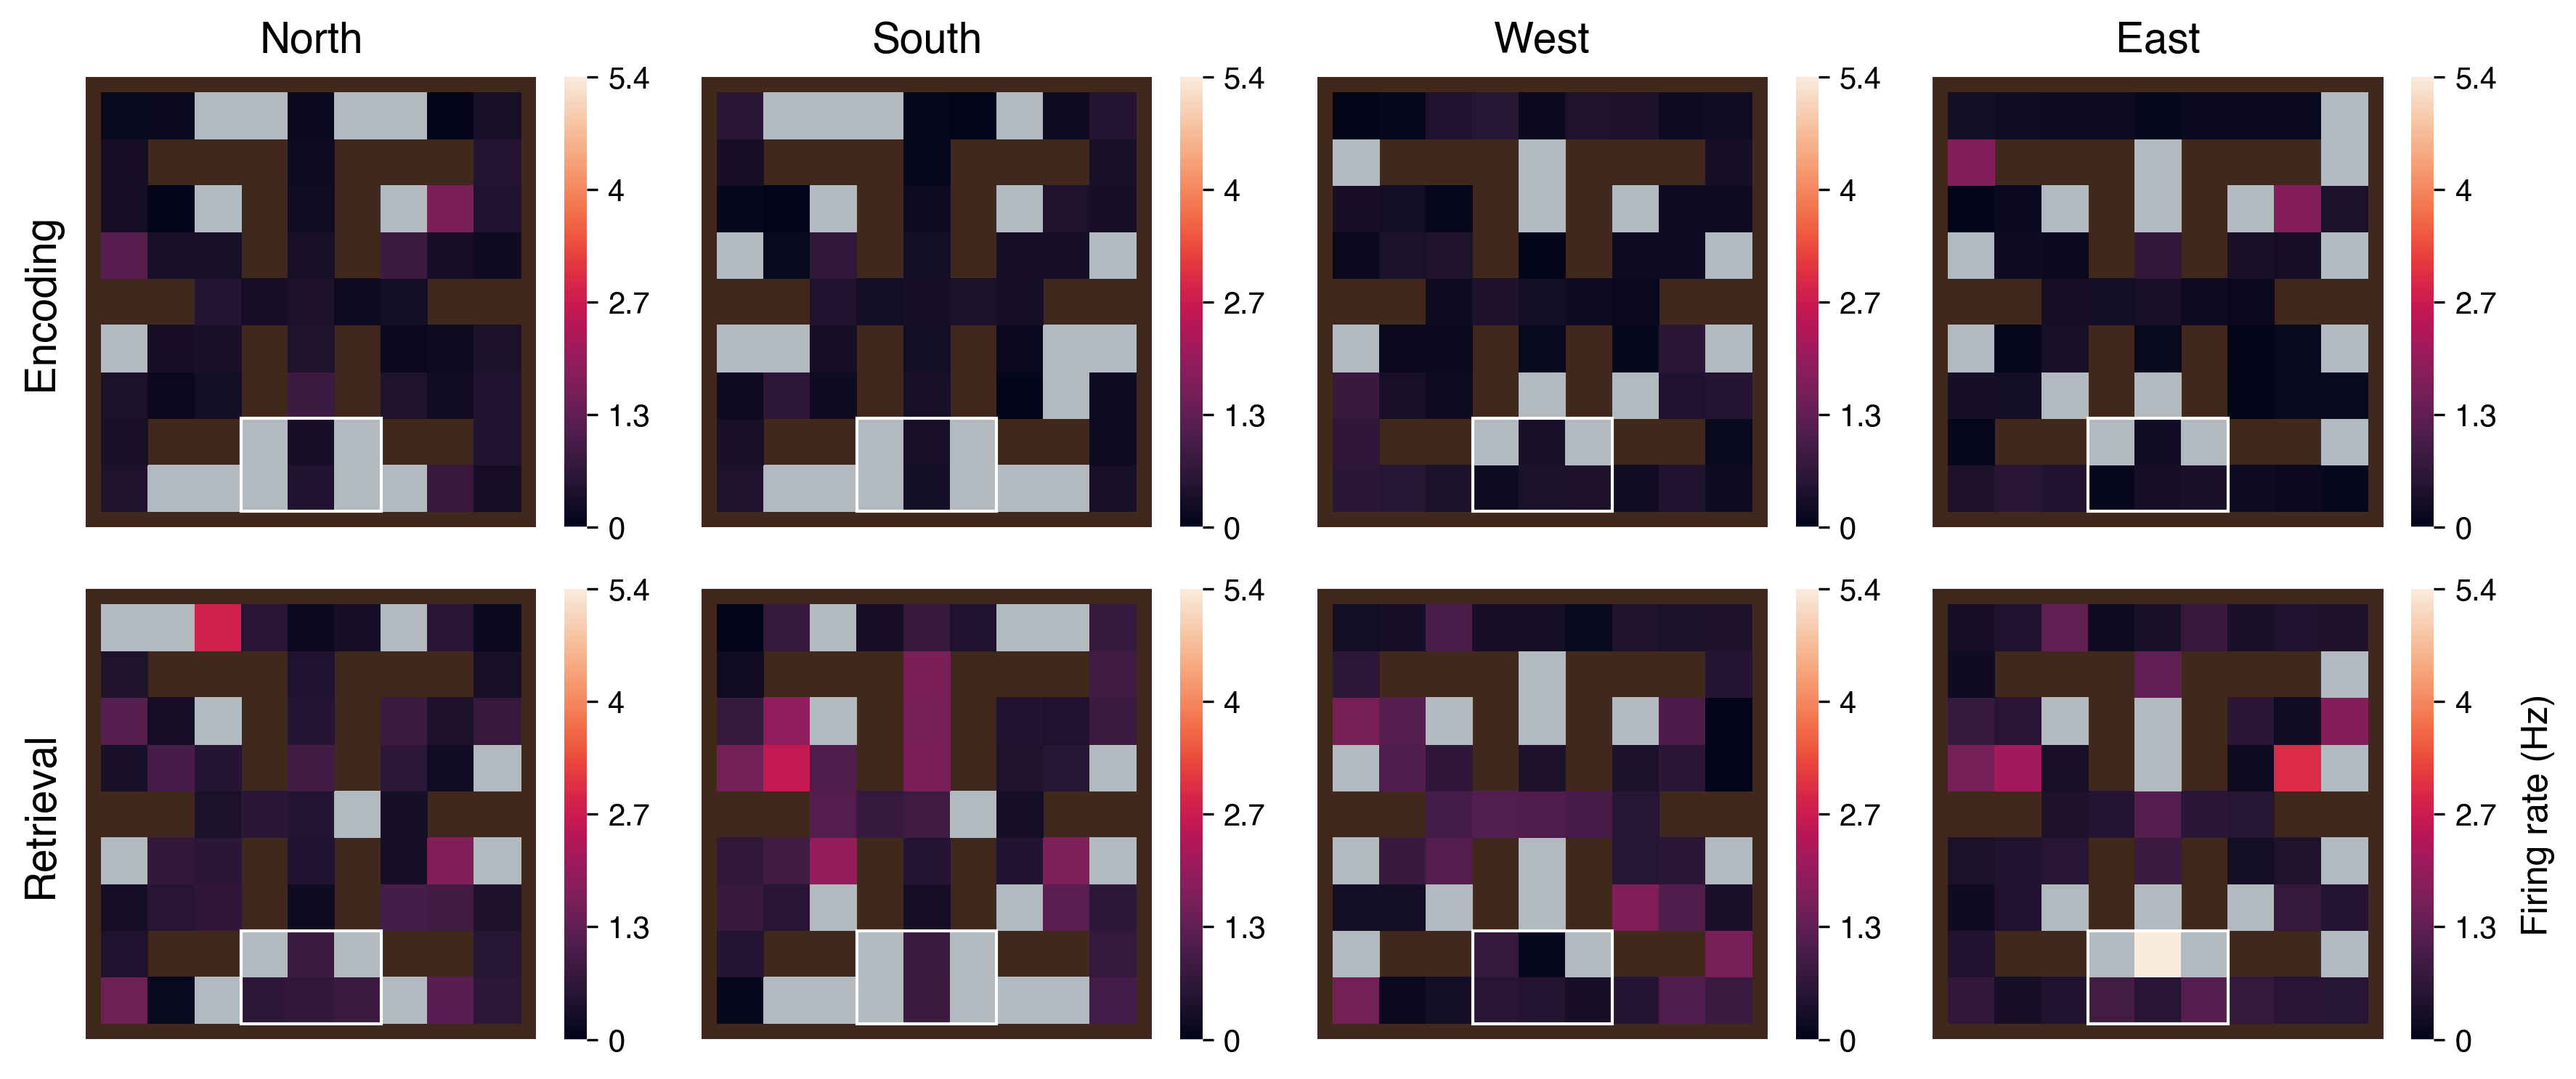

In [478]:
iUnit = 21
idx_on = 'maze_idx_hd'
game_states = ['Encoding', 'Retrieval']
min_traversals = 0

neuron = dio.open_pickle(files[iUnit])
fr_by_pos = place_analysis.calc_fr_by_pos(neuron,
                                          events.event_times,
                                          pos_time_idx)

plt.close()
fig, ax = plt.subplots(2, 4, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

vmin = 0
vmax = np.max([list(fr_by_pos[game_state].values()) for game_state in fr_by_pos.keys()])

for iRow, game_state in enumerate(game_states):
    i = (4*iRow) + 0
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    ax[i].set_ylabel(game_state, fontsize=events.plot_params['font']['fig'], labelpad=8)
    if iRow == 0:
        ax[i].set_title('North', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 1
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.5)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('South', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 2
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.75)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('West', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 3
    cbar_label = 'Firing rate (Hz)' if (iRow == 1) else ''
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.25)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 cbar_label=cbar_label,
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('East', fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

# Primary head direction

In [79]:
import astropy.stats.circstats as circstats
import pycircstat

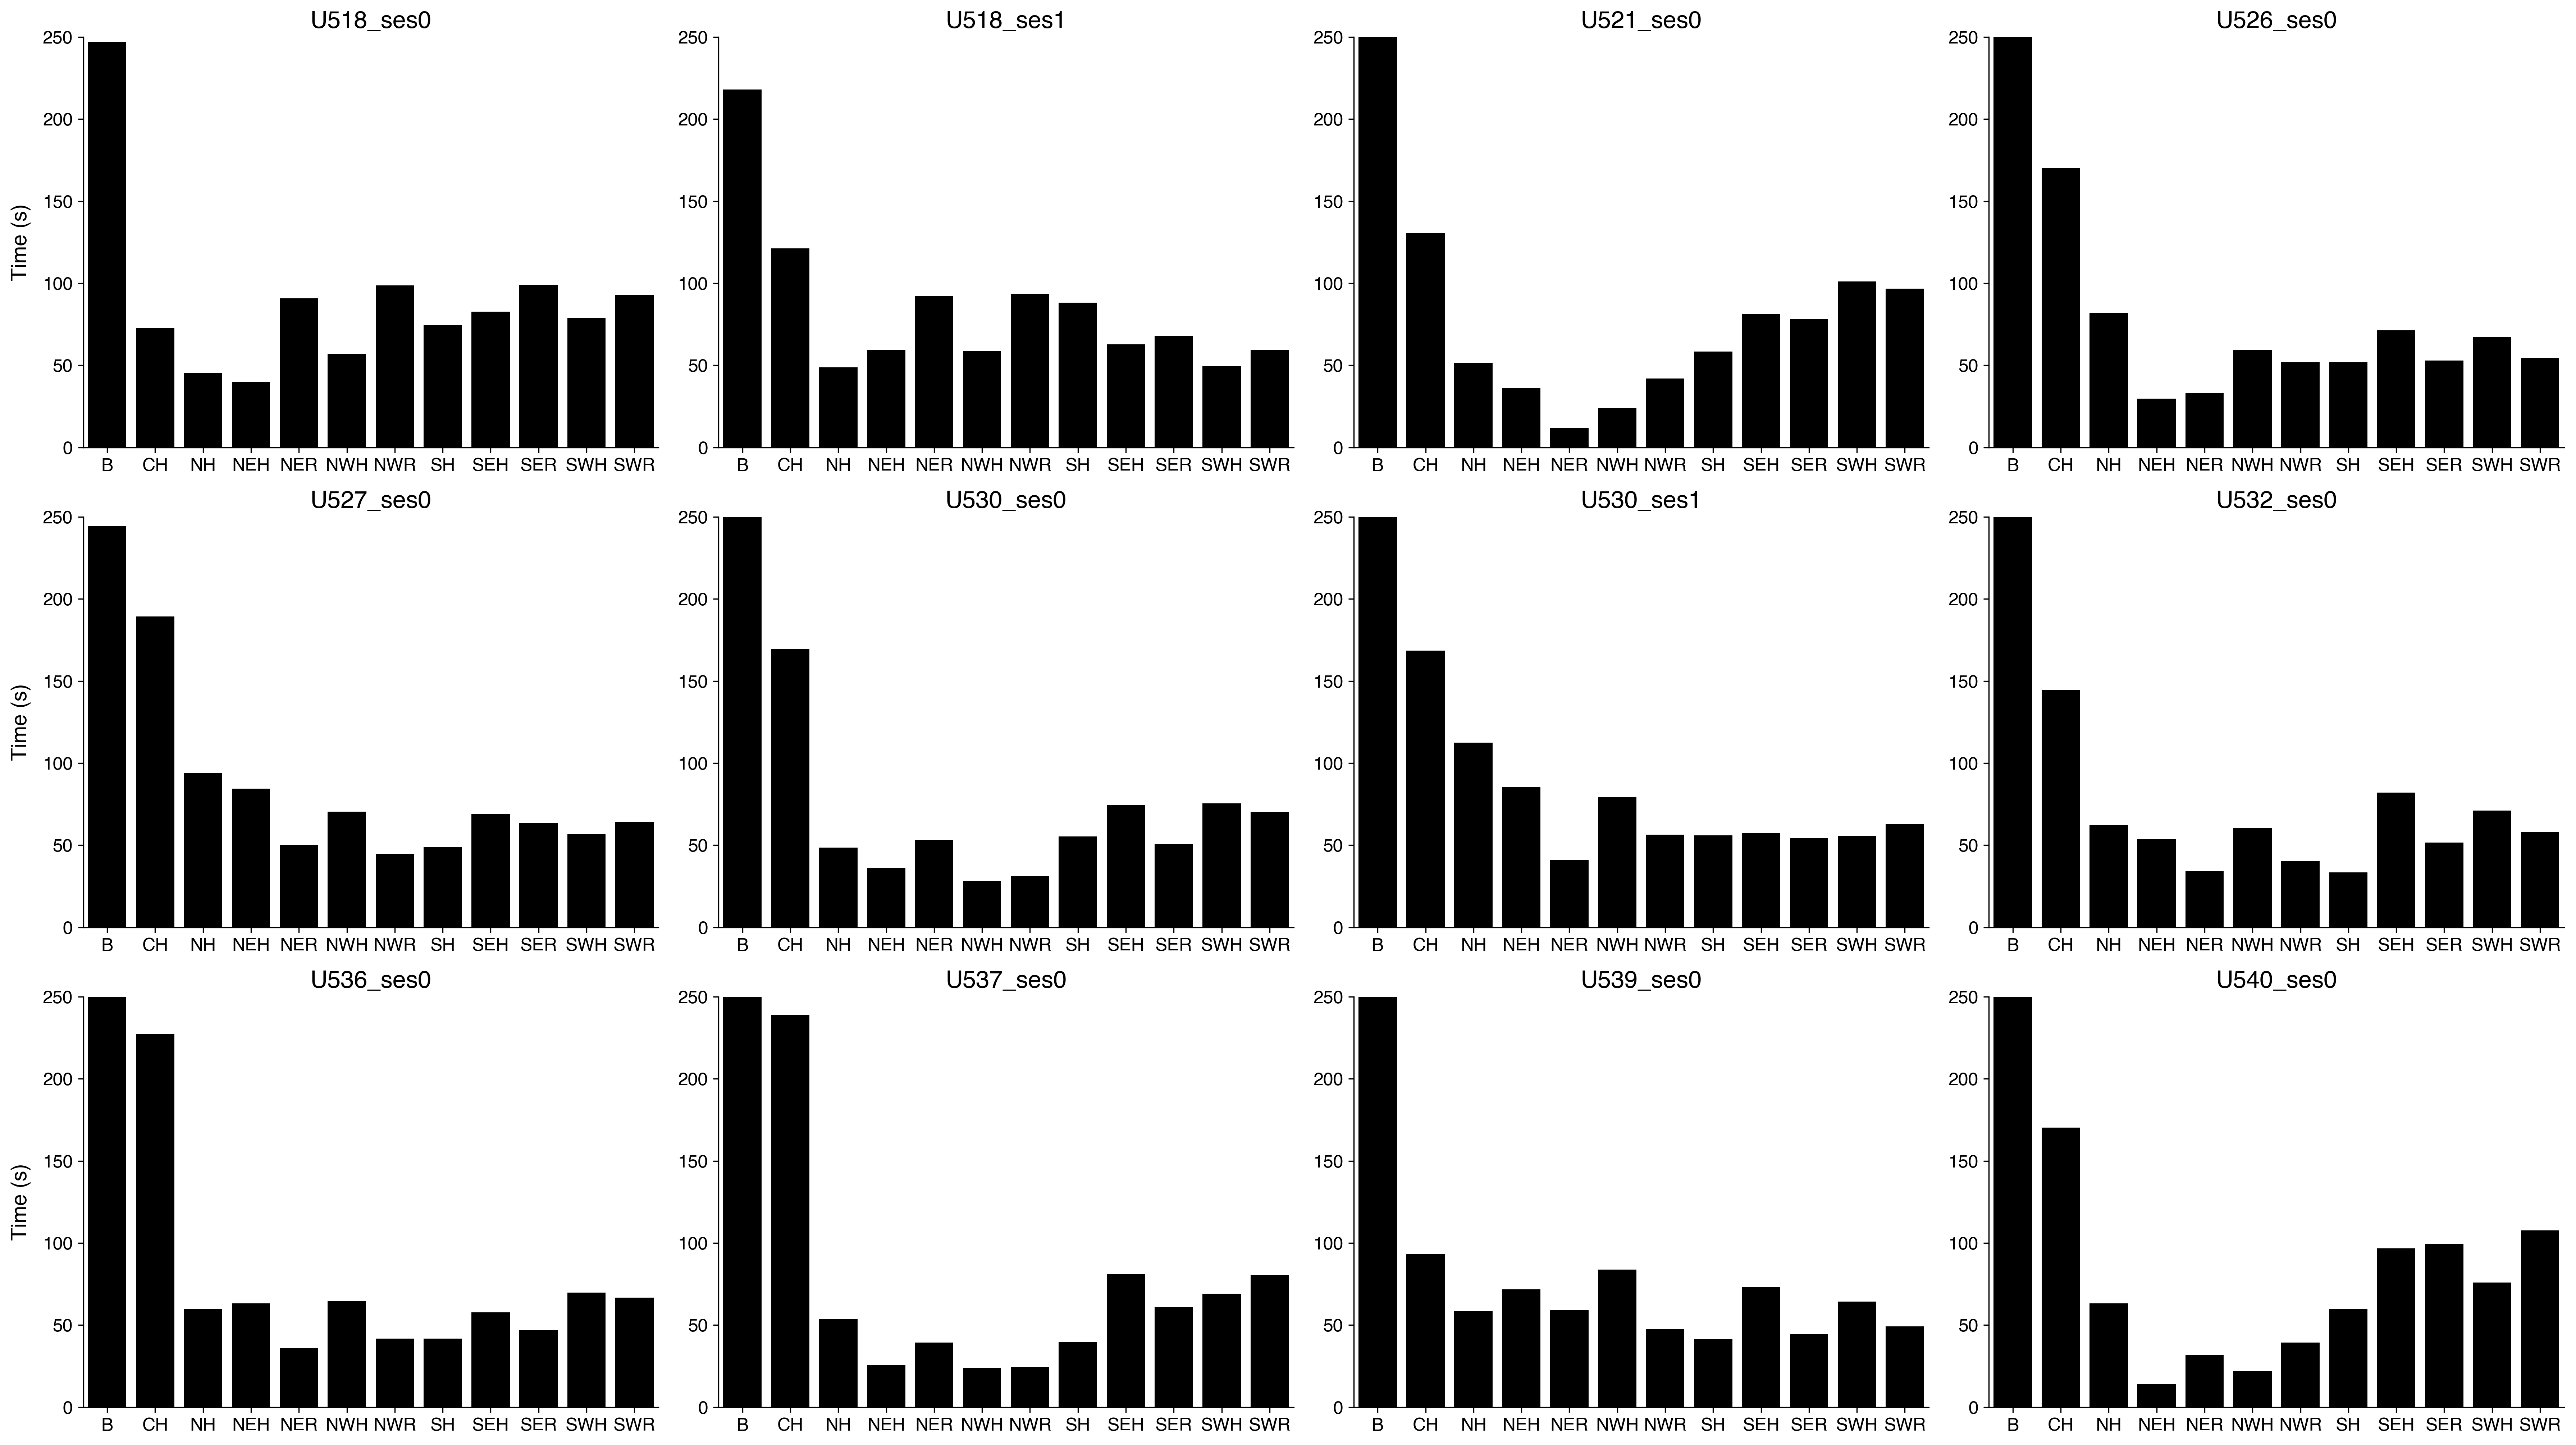

In [121]:
ylim = [0, 250]
yticks = [0, 50, 100, 150, 200, 250]
abbvs = {'Base': 'B',
         'C Hall': 'CH',
         'N Passage': 'NH',
         'NE Hall': 'NEH',
         'NE Room': 'NER',
         'NW Hall': 'NWH',
         'NW Room': 'NWR',
         'S Passage': 'SH',
         'SE Hall': 'SEH',
         'SE Room': 'SER',
         'SW Hall': 'SWH',
         'SW Room': 'SWR'}

plt.close()
fig, ax = plt.subplots(3, 4, figsize=(24, 13.5), dpi=300)
ax = np.ravel(ax)

mean_df = []
iax = 0
for iax, subj_sess in enumerate(events.keys()):
    positions = events[subj_sess].positions.query("(gameState=='Encoding')").reset_index(drop=True)
    positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])
    region_abbvs = ['B', 'CH', 'NH', 'NEH', 'NER', 'NWH', 'NWR', 'SH', 'SEH', 'SER', 'SWH', 'SWR']
    positions['region_abbv'] = positions['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))
    _df = (positions#.query("(region_abbv!='B')")
                    .groupby('region_abbv', observed=True)['dur']
                    .apply(lambda x: np.sum(x) * 1e-3)
                    .reset_index()
                    .rename(columns={0: 'count'}))
    mean_df.append(_df)
    ax[iax] = sns.barplot(data=_df, x='region_abbv', y='dur', ax=ax[iax],
                          color='k')
    ax[iax].set_ylim(ylim)
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks)
    ax[iax].set_xlabel('')
    if (iax % 4) == 0:
        ax[iax].set_ylabel('Time (s)')
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(subj_sess)
    
fig.tight_layout()
fig.set_facecolor('w')
fig.show()

In [157]:
abbvs = {'Base': 'B',
         'C Hall': 'CH',
         'N Passage': 'NH',
         'NE Hall': 'NEH',
         'NE Room': 'NER',
         'NW Hall': 'NWH',
         'NW Room': 'NWR',
         'S Passage': 'SH',
         'SE Hall': 'SEH',
         'SE Room': 'SER',
         'SW Hall': 'SWH',
         'SW Room': 'SWR'}
# region_abbvs = ['B', 'CH', 'NH', 'NEH', 'NER', 'NWH', 'NWR', 'SH', 'SEH', 'SER', 'SWH', 'SWR']
region_abbvs = ['B', 'SH', 'CH', 'NH', 'SWH', 'SWR', 'NWR', 'NWH', 'SEH', 'SER', 'NER', 'NEH']

positions = []
for subj_sess in events:
    subj, sess = subj_sess.split('_')
    _positions = events[subj_sess].positions.query("(gameState==['Encoding', 'Retrieval'])")
    _positions.insert(0, 'subj', subj)
    _positions.insert(1, 'subj_sess', subj_sess)
    positions.append(_positions)

positions = pd.concat(positions).reset_index(drop=True)
positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])

pos_durs = positions.groupby(['subj', 'subj_sess', 'gameState', 'region_abbv'])['dur'].apply(lambda x: np.sum(x) * 1e-3).reset_index()
pos_durs = pos_durs.groupby(['subj', 'gameState', 'region_abbv'])['dur'].apply(np.mean).reset_index()
pos_durs['region_abbv'] = pos_durs['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))
pos_durs = pos_durs.sort_values(['region_abbv', 'subj', 'gameState']).reset_index(drop=True)

print(positions.shape, pos_durs.shape)

(505655, 18) (240, 4)


In [166]:
pos_durs

subj  gameState region_abbv      dur
0    U518   Encoding           B  232.559
1    U518  Retrieval           B  249.697
2    U521   Encoding           B  338.835
3    U521  Retrieval           B  292.921
4    U526   Encoding           B  356.113
..    ...        ...         ...      ...
235  U537  Retrieval         NEH   36.503
236  U539   Encoding         NEH   71.780
237  U539  Retrieval         NEH   38.567
238  U540   Encoding         NEH   14.150
239  U540  Retrieval         NEH   18.199

[240 rows x 4 columns]

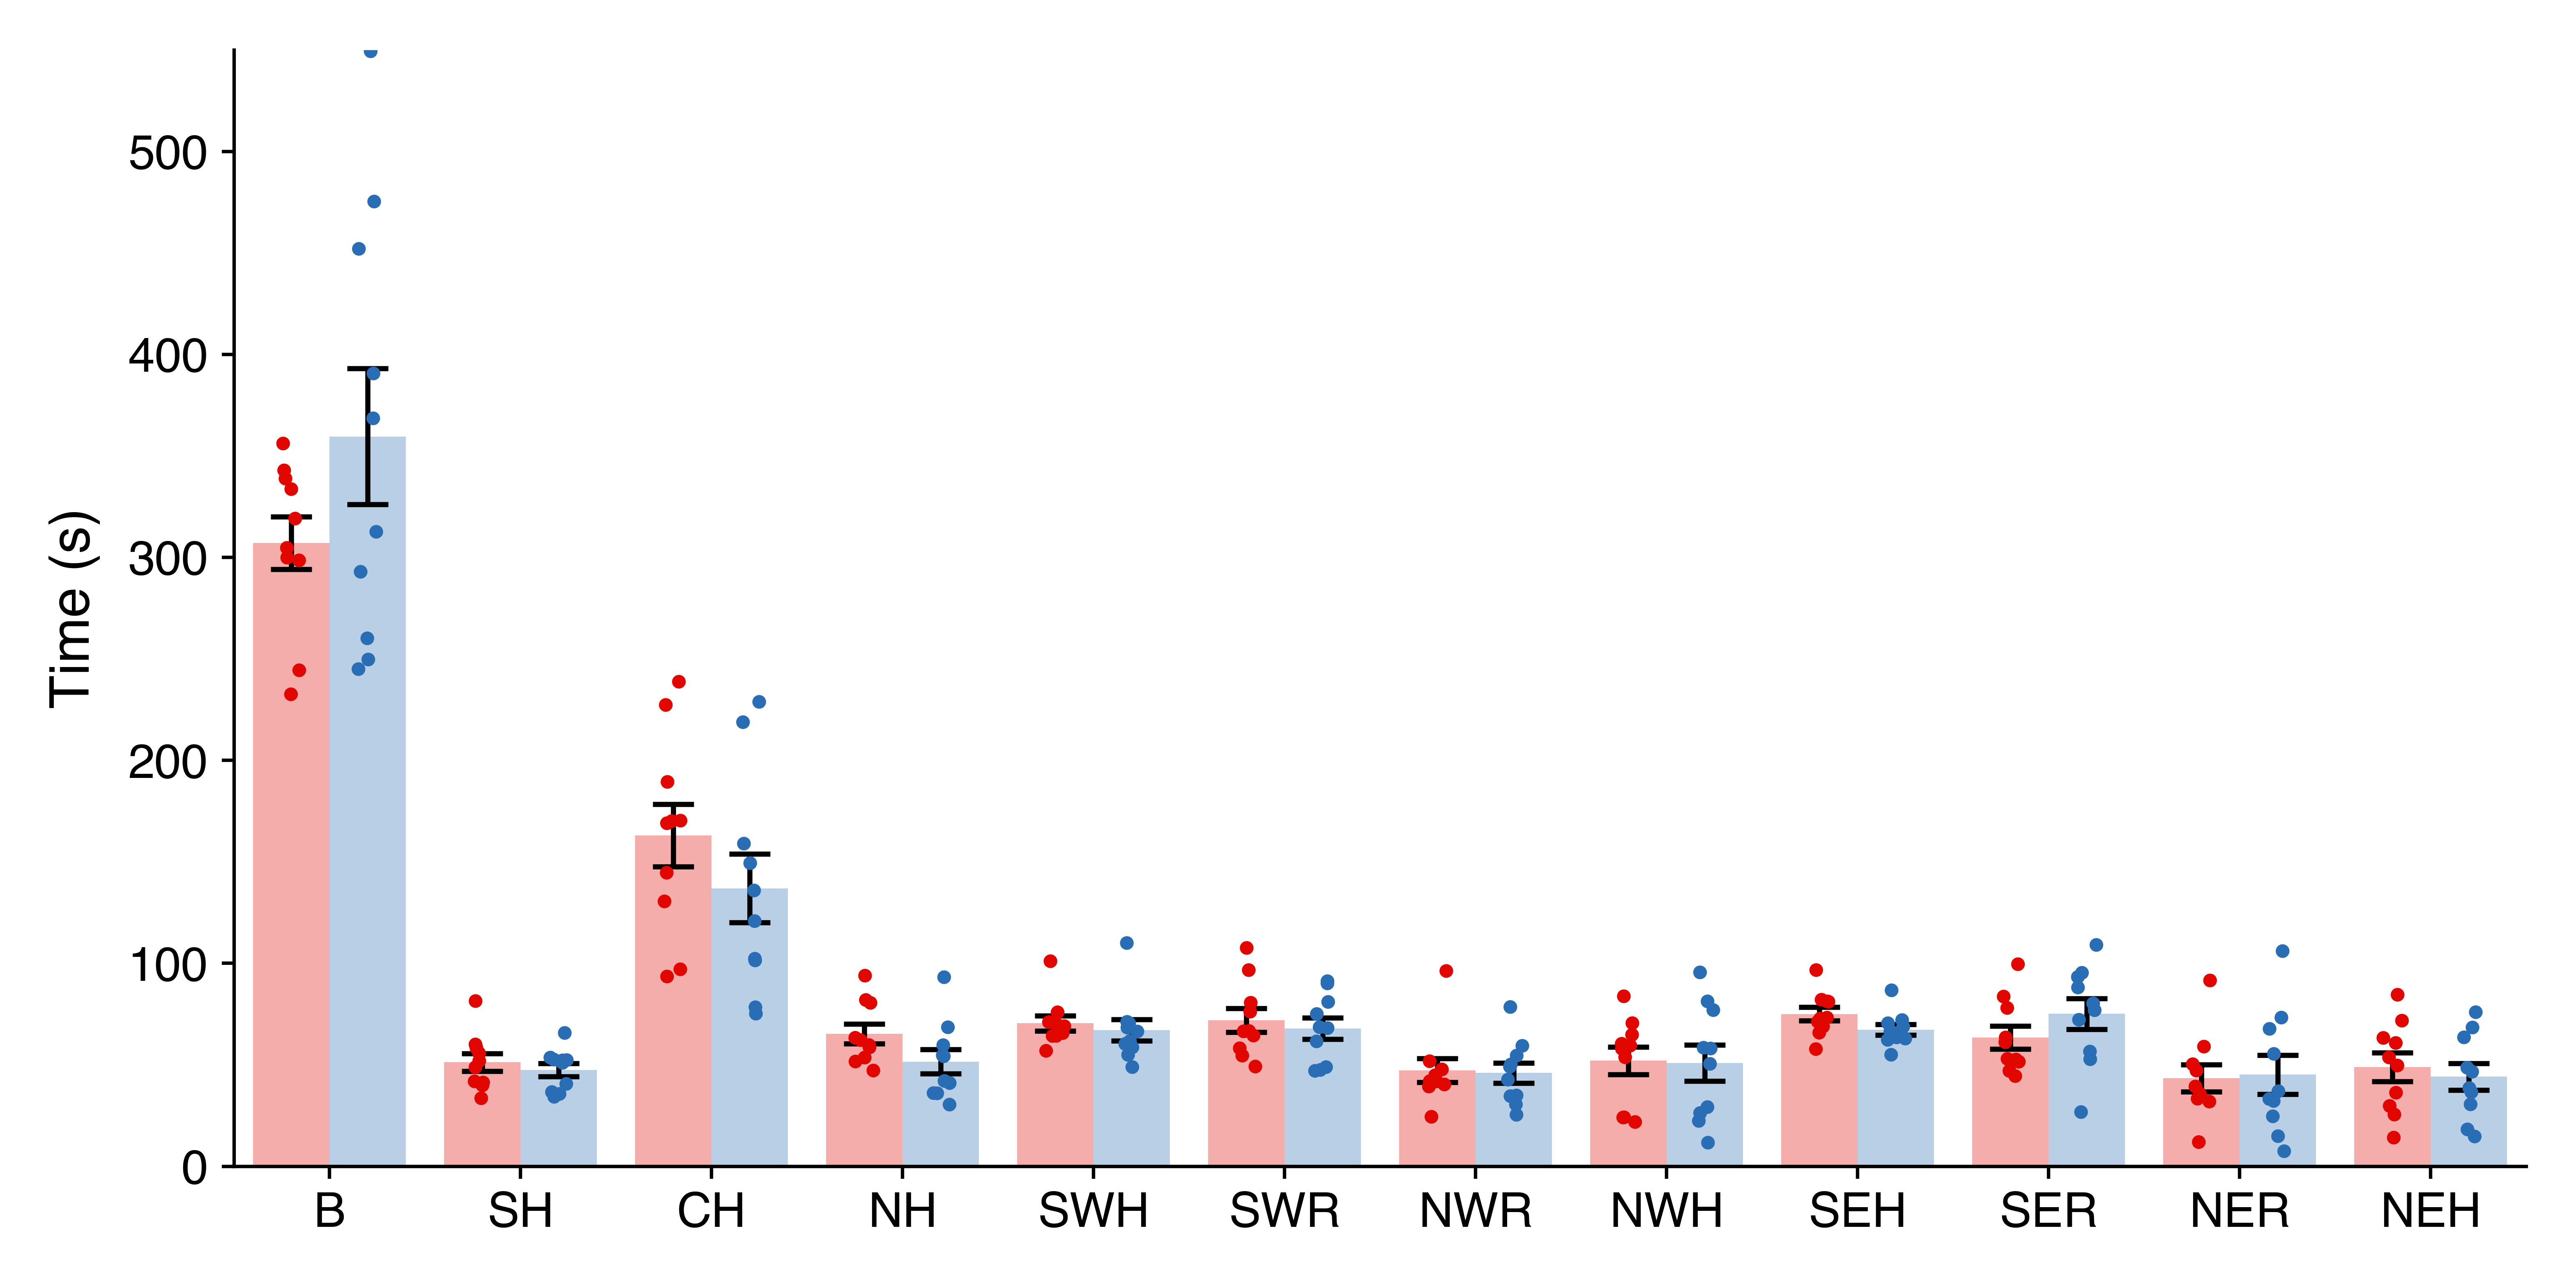

In [183]:
savefig = 1
overwrite = 0
ymin = 0
ymax = 550
yticks = [0, 100, 200, 300, 400, 500]
game_states = ['Encoding', 'Retrieval']
figsize = (6, 3)
dpi = 1200
font = {'tick': 7, 'label': 8, 'annot': 10, 'fig': 12}
spine_len = 1.8
spine_lw = 0.5
spine_pad = 1
labelpad = 4
tickpad = 2
alpha = 0.33
capsize = 3
ebar_lw = 0.75
fliersize = 2

# --------------------
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.barplot(x='region_abbv', y='dur', hue='gameState', data=pos_durs, ax=ax[iax],
                      ci=None, palette=['#e10600', '#296eb4'], saturation=1, alpha=alpha)
ax[iax].errorbar(np.arange(len(region_abbvs))-0.2,
                 pos_durs.query("(gameState=='Encoding')").groupby('region_abbv', sort=False)['dur'].mean().values,
                 yerr=pos_durs.query("(gameState=='Encoding')").groupby('region_abbv', sort=False)['dur'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=capsize, capthick=ebar_lw, linewidth=0)
ax[iax].errorbar(np.arange(len(region_abbvs))+0.2,
                 pos_durs.query("(gameState=='Retrieval')").groupby('region_abbv', sort=False)['dur'].mean().values,
                 yerr=pos_durs.query("(gameState=='Retrieval')").groupby('region_abbv', sort=False)['dur'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=capsize, capthick=ebar_lw, linewidth=0)
ax[iax] = sns.stripplot(x='region_abbv', y='dur', hue='gameState', data=pos_durs, ax=ax[iax],
                        palette=['#e10600', '#296eb4'], size=fliersize, alpha=1, dodge=True, jitter=0.1)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(len(region_abbvs)))
ax[iax].set_xticklabels(region_abbvs, fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin, ymax])
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
ax[iax].set_ylabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].get_legend().remove()

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_behav',
                       'time_spent_per_maze_region-Encoding_Retrieval-{}subjs.pdf'
                       .format(pos_durs['subj'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [122]:
pd.concat(mean_df).groupby('region_abbv')['dur'].mean().reset_index()

region_abbv         dur
0            B  301.863250
1           CH  158.067917
2           NH   65.036333
3          NEH   49.987000
4          NER   47.785333
5          NWH   52.702083
6          NWR   51.041833
7           SH   54.171083
8          SEH   74.140333
9          SER   64.234000
10         SWH   69.591000
11         SWR   71.940667

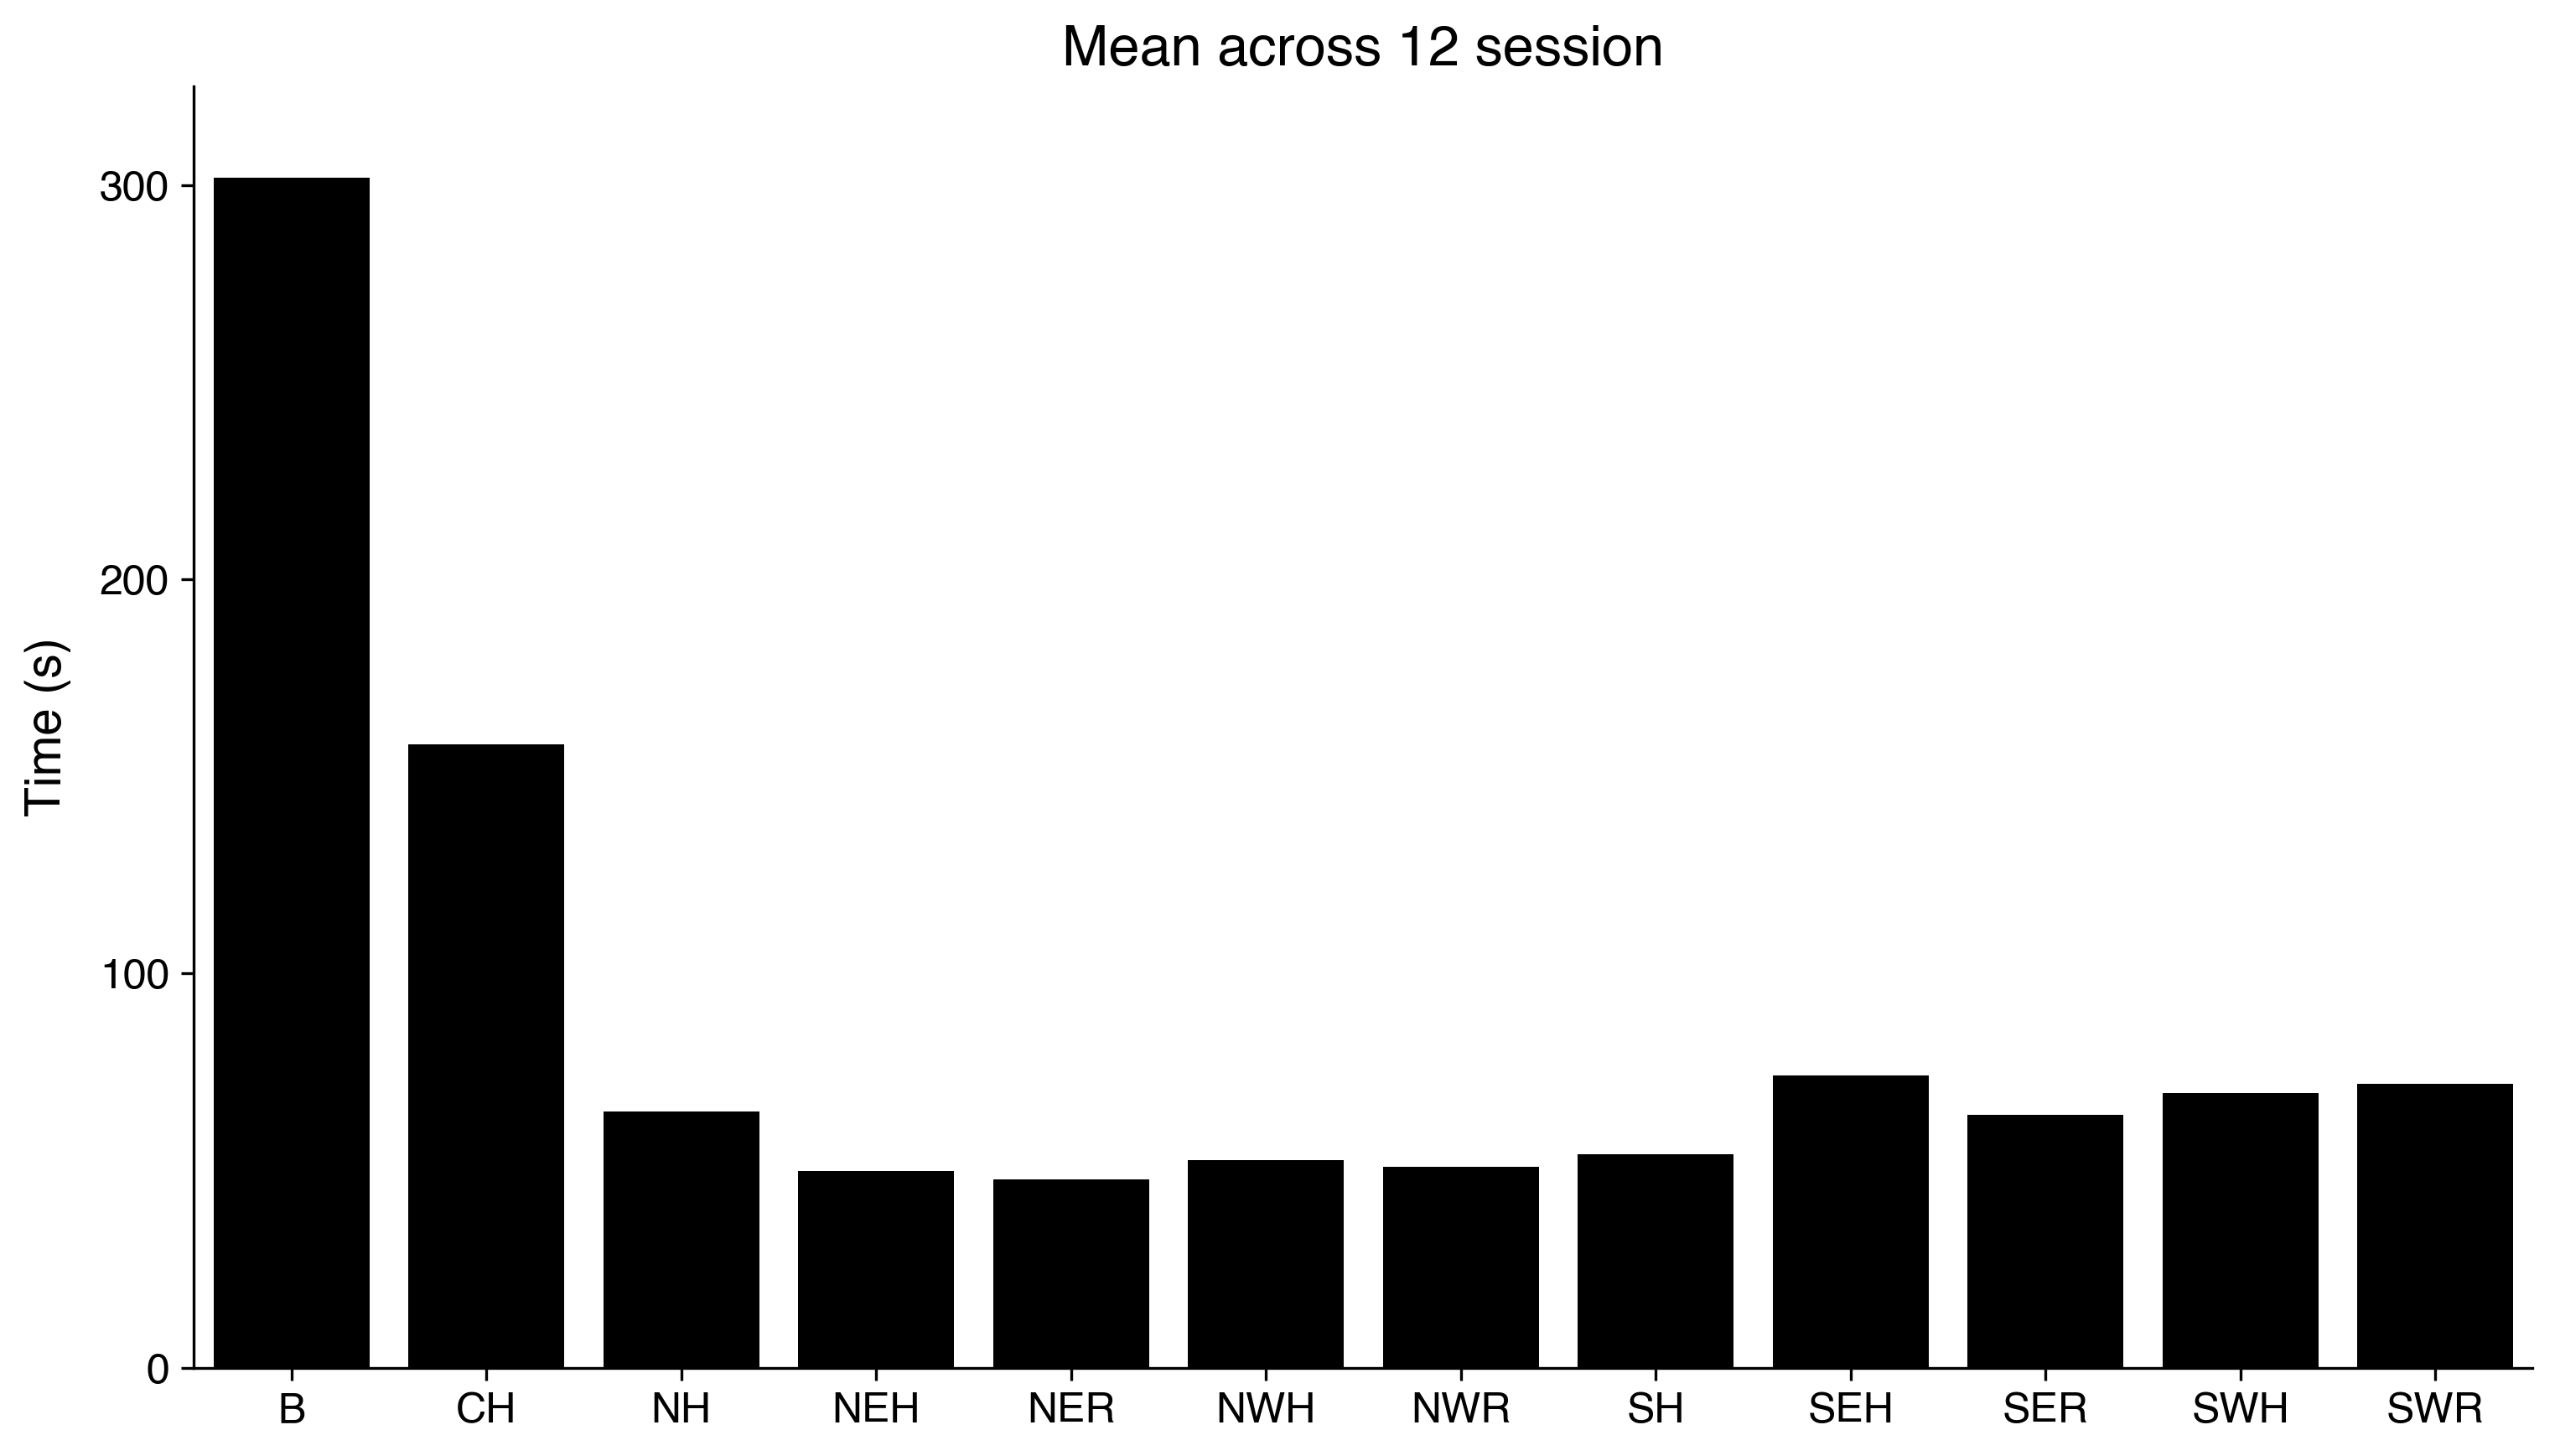

In [124]:
ylim = [0, 325]
yticks = [0, 100, 200, 300]

_df = pd.concat(mean_df).groupby('region_abbv')['dur'].mean().reset_index()

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12, 13.5/2), dpi=300)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.barplot(data=_df, x='region_abbv', y='dur', ax=ax[iax],
                      color='k')
ax[iax].set_ylim(ylim)
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks)
ax[iax].set_xlabel('')
ax[iax].set_ylabel('Time (s)')
ax[iax].set_title('Mean across {} session'.format(len(mean_df)))

fig.set_facecolor('w')
fig.show()

In [186]:
_gold_events.groupby('gold_id')['time'].apply(lambda x: np.mean(np.diff(x)))

gold_id
gold0001    249.983193
gold0002    250.000000
gold0003    249.991597
gold0004    250.008403
gold0005    249.991597
gold0006    249.991597
gold0007    250.000000
gold0008    250.000000
gold0009    249.991597
gold0010    250.008403
gold0011    250.000000
gold0012    249.991597
gold0013    250.008403
gold0014    249.991597
gold0015    250.000000
gold0016    250.000000
gold0017    250.008403
gold0018    249.991597
gold0019    249.991597
gold0020    249.991597
gold0021    250.000000
gold0022    249.991597
gold0023    250.134454
gold0024    249.991597
gold0025    249.991597
gold0026    250.000000
gold0027    249.991597
gold0028    249.991597
gold0029    250.000000
gold0030    249.991597
gold0031    250.008403
gold0032    249.991597
gold0033    250.000000
gold0034    249.991597
gold0035    249.991597
gold0036    250.000000
gold0037    250.000000
gold0038    249.983193
gold0039    249.991597
gold0040    249.991597
gold0041    249.991597
gold0042    250.000000
gold0043    249.991525
gol

In [191]:
#events[subj_sess].gold_spawned

In [189]:
_gold_events = events[subj_sess].gold_events.query("(gameState=='Encoding')").reset_index(drop=True)

_gold_events.query("(in_view==True)").groupby('gold_id').size() * 250 * 1e-3

gold_id
gold0003    12.00
gold0004     5.25
gold0006     3.50
gold0007     2.50
gold0010     3.25
gold0012     2.75
gold0016     2.50
gold0017     2.75
gold0018     3.00
gold0020     6.00
gold0023     1.75
gold0024     3.75
gold0025     2.50
gold0027     2.25
gold0028     3.75
gold0029     2.50
gold0030     4.50
gold0031     5.25
gold0034     3.25
gold0035     0.50
gold0037     3.25
gold0039     1.25
gold0041    24.75
gold0042     2.75
gold0043     3.25
gold0044     6.25
gold0047    11.50
dtype: float64

In [119]:
def deg2rad(angles):
    """Convert angles from degree to radian."""
    angles %= 360.0
    angles = (angles / 360.0) * (2 * np.pi)
    return angles

def rad2deg(angles):
    """Convert angles from radian to degree."""
    angles %= (2 * np.pi)
    angles = (angles / (2 * np.pi)) * 360.0
    return angles

In [144]:
positions.query("(region_abbv!='B')").groupby('region_abbv', observed=True).size().reset_index().rename(columns={0: 'count'})


region_abbv     0
0           CH  3409
1           NP  1267
2          NEH   283
3          NER   638
4          NWH   438
5          NWR   786
6           SP  1201
7          SEH  1934
8          SER  1993
9          SWH  1519
10         SWR  2152

In [133]:
subj_sess = sessions[-1]
print(subj_sess)


positions = events[subj_sess].positions.query("(gameState=='Encoding')").reset_index(drop=True)
positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])
region_abbvs = ['B', 'CH', 'NP', 'NEH', 'NER', 'NWH', 'NWR', 'SP', 'SEH', 'SER', 'SWH', 'SWR']
positions['region_abbv'] = positions['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))

positions.groupby(['maze_region']).agg({'dur': len,
                                        'rotation': [lambda x: rad2deg(circstats.circmean(deg2rad(x))),
                                                     lambda x: pycircstat.omnibus(deg2rad(x)),
                                                     lambda x: circstats.rayleightest(deg2rad(x))]})

U540_ses0


dur    rotation                                       \
              len  <lambda_0>                           <lambda_1>   
maze_region                                                          
Base         5990  346.736025  (1.5394244040527593e-143, [1997.0])   
C Hall       3409   40.020188    (3.684990927108853e-82, [1134.0])   
N Passage    1267    7.738820    (1.325608391197101e-125, [204.0])   
NE Hall       283  120.024550        (9.46660127943817e-61, [0.0])   
NE Room       638  252.251872     (7.670237132314288e-34, [160.0])   
NW Hall       438  252.144546      (8.069973129711075e-39, [78.0])   
NW Room       786  260.466452     (5.324437731696767e-13, [283.0])   
S Passage    1201    4.206166     (9.201428765147792e-95, [237.0])   
SE Hall      1934   19.008474     (3.875324421633409e-64, [587.0])   
SE Room      1993  301.010049    (3.3463166720352026e-37, [702.0])   
SW Hall      1519  321.339427   (1.2066180920941822e-151, [243.0])   
SW Room      2152   50.684764   (4.2824981135619713e-100, [576.0])   

                            
                <lambda_2>  
maze_region                 
Base         1.966265e-120  
C Hall        6.337979e-56  
N Passage    4.967562e-150  
NE Hall       7.134965e-66  
NE Room       1.093135e-16  
NW Hall       1.599135e-43  
NW Room       1.791869e-10  
S Passage    4.179092e-146  
SE Hall       1.327189e-59  
SE Room       5.271173e-37  
SW Hall      1.420826e-170  
SW Room      1.327108e-121

# Older position code

In [72]:
# Where did the subject go in the mine?
min_traversals = 0

# -------------------------------------
cols = ['trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
game_states = ['Encoding', 'Retrieval', 'ReturnToBase1', 'ReturnToBase1']
mask_regions = ['wall', 'base']
traversals = []
for idx, df in (events.query("(key=='playerTransform') & (gameState=={})".format(game_states))
                .groupby(['trial', 'gameState'])):
    trial, gameState = idx
    if maze_name == 'SimpleMaze':
        pos = np.array(df['value'].apply(lambda x: (int(x['positionX'])-4, int(x['positionZ'])-1)).tolist(), time_bin_analysis.)
    else:
        pos = np.array(df['value'].apply(lambda x: (int(x['positionX']), int(x['positionZ']))).tolist(), time_bin_analysis.)
    dist_trav = np.concatenate(([0], np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))))
    traversals.extend([x for x in pos[dist_trav>0]])
traversals = np.array(traversals)
positions, counts = np.unique(traversals, axis=0, return_counts=True)

maze_map = np.zeros([27, 29])
for iPos in range(len(positions)):
    maze_map[tuple(positions[iPos])] = counts[iPos]

# Mask out unwanted regions.
mask = np.zeros([27, 29])
for region in mask_regions:
    for idx, row in maze.query("(region=='{}')".format(region)).iterrows():
        (xmin, zmin), (xmax, zmax) = row.coords
        for x in range(xmin, xmax):
            for z in range(zmin, zmax):
                maze_map[x, z] = 0
                mask[x, z] = 1

# Mask out squares that the subject didn't visit.
maze_map[maze_map<min_traversals] = 0

print('{} squares traversed'.format(maze_map[maze_map>0].size))
print('No. traversals: median {:.1f}, max {:.1f}, sum {:.0f}'.format(np.median(maze_map[maze_map>0]), 
                                                                     np.max(maze_map), 
                                                                     np.sum(maze_map)))

340 squares traversed
No. traversals: median 9.5, max 35.0, sum 3661


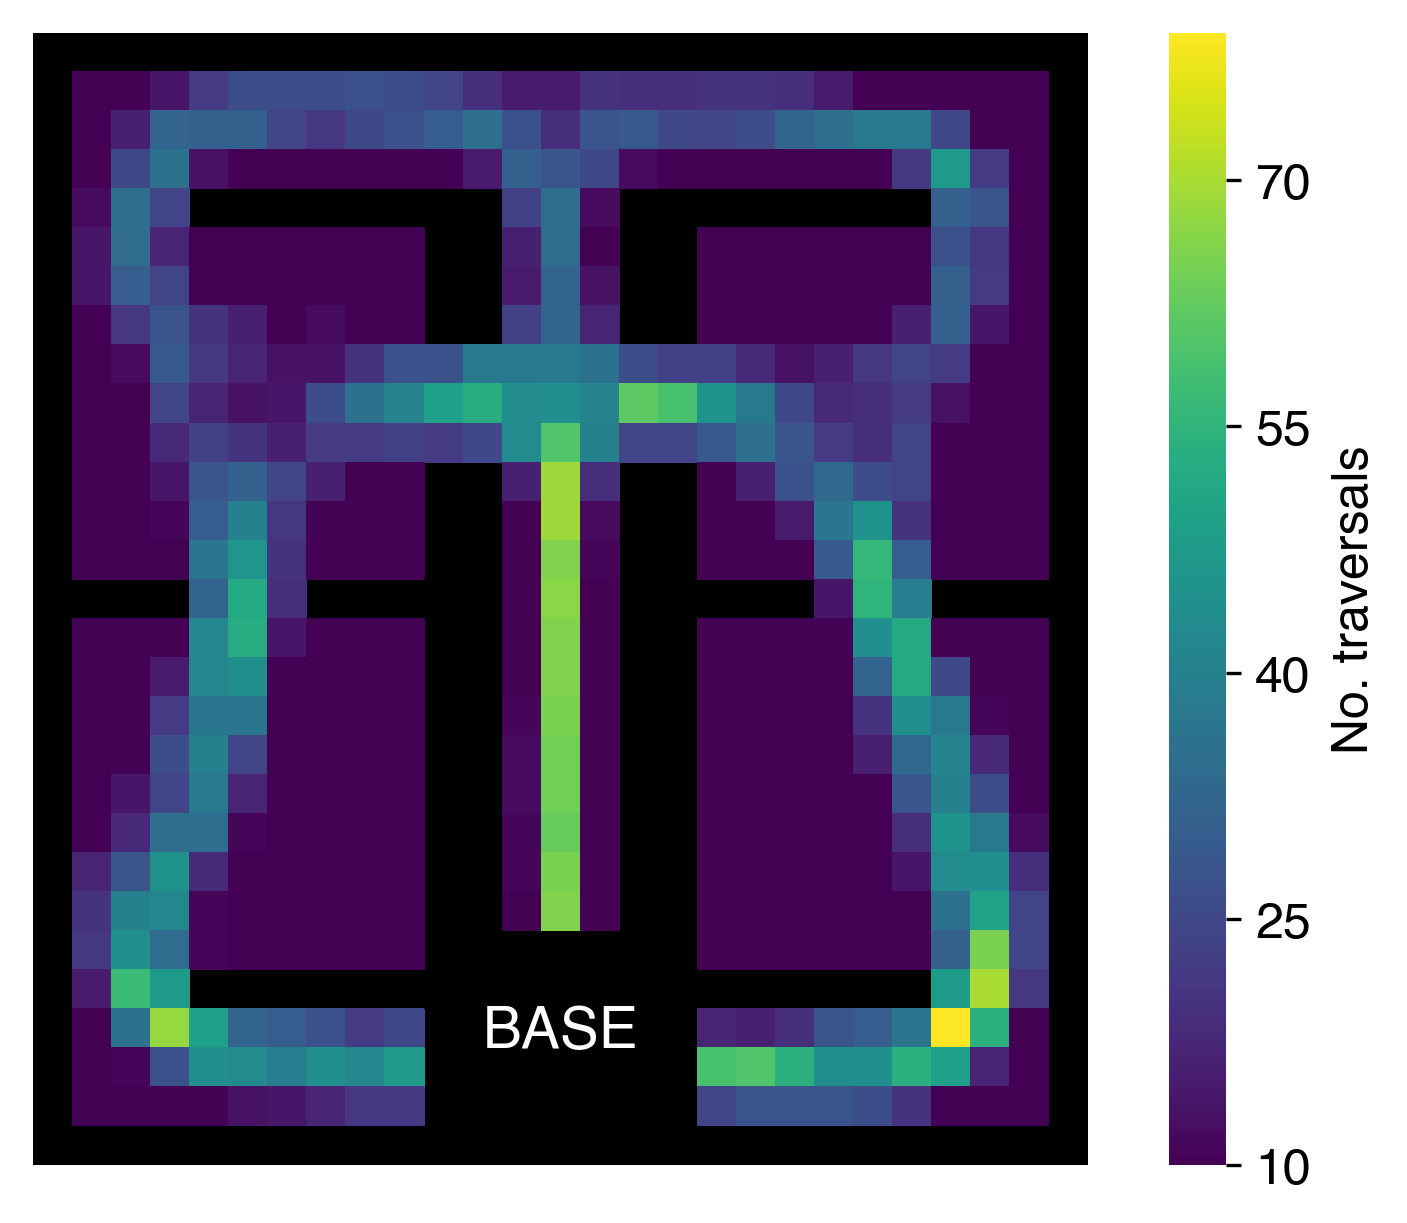

In [580]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14
cmap = [(0, 0, 0)] + sns.color_palette('viridis', 500)

i = 0
ax[i] = sns.heatmap(maze_map.T[::-1], vmin=min_traversals, vmax=np.max(maze_map),
                    square=True, cmap='viridis', mask=mask.T[::-1], ax=ax[i])
ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize, ha='center')
ax[i].set_facecolor('k')

ax[i].set_xticks([])
ax[i].set_yticks([])
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.arange(min_traversals, np.max(maze_map)+1, 15, dtype=int))
cbar.set_ticklabels(np.arange(min_traversals, np.max(maze_map)+1, 15, dtype=int))
cbar.set_label('No. traversals', fontsize=tickfontsize, labelpad=5)

fig.show()

In [ ]:
# How much distance is traveled, and how much time spent moving vs. standing still?
cols = ['sess', 'trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
positions = []
for idx, df in events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['sess', 'trial', 'gameState']):
    sess, trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([sess, trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

In [318]:
travel.groupby(['gameState', 'time_penalty']).agg({'sess': len, 'dist_trav': lambda x: np.mean(x)}).reset_index()

gameState  time_penalty  sess  dist_trav
0   Encoding             0    36  57.948854
1   Encoding             1    36  63.523718
2  Retrieval             0    36  58.281867
3  Retrieval             1    36  62.319022

# Construct maze DataFrame

In [51]:
def area(coords):
    """Return the area of a rectangle in m^2.
    
    Parameters
    ----------
    coords: list of lists
        Rectangle coordinates like [(x1, y1), (x2, y2)]
    """
    coords = np.array(coords)
    return np.abs(np.prod(coords[1, :] - coords[0, :]))

def dist_from_point(coords,
                    point):
    """Return distance between coords and a comparison point.
    
    Distance is in virtural meters.
    
    Parameters
    ----------
    coords : list[list]
        Rectangle coordinates like [(x1, y1), (x2, y2)]
    point : list
        (x, y)
    """
    coords = np.array(coords)
    point = np.array(point)
    coord_center = (coords[0, :] + coords[1, :]) / 2
    return np.linalg.norm(coord_center - point)

In [106]:
if False:
    proj_dir = '/home1/dscho/projects/time_cells'
    dio.save_pickle(maze, os.path.join(proj_dir, 'unity', 'maps', 'SMaze2.pkl'))

Saved /home1/dscho/projects/time_cells/unity/maps/SMaze2.pkl


In [100]:
maze_f = '/home1/dscho/projects/time_cells/unity/maps/SimpleMaze.pkl'
maze = dio.open_pickle(maze_f)
maze_name = op.basename(maze_f).split('.')[0]

In [75]:
# coords = maze['coords'].tolist()
# coords[51] = [(13, 25), (15, 28)]
# coords[52] = [(18, 25), (20, 28)]
# coords[66] = [(15, 25), (18, 28)]
# maze['coords'] = coords

[(13, 25), (16, 28)]

In [89]:
if 'area' not in maze.columns:
    maze['area'] = maze['coords'].apply(lambda x: area(x))
    
if 'dist_from_spawn' not in maze.columns:
    if maze_name == 'SimpleMaze':
        player_spawn = np.array([16.5, 1.6])
    elif maze_name == 'SMaze2':
        player_spawn = np.array([13.5, 1.5])
    maze['dist_from_spawn'] = maze['coords'].apply(lambda x: dist_from_point(x, player_spawn))

In [90]:
maze_idx = {'SimpleMaze': [[0, 1, 2, 57],
                           [3, 4, 5, 61],
                           [48, 49, 50, 51, 60],
                           [52, 53, 54, 55, 64],
                           [6, 7, 8, 9, 10, 11, 12, 13, 14, 58],
                           [21, 22, 23, 24, 25, 26, 27, 28, 29, 62],
                           [30, 31, 32, 33, 34, 35, 36, 37, 38],
                           [39, 40, 41, 42, 43, 44, 45, 46, 47],
                           [56],
                           [66, 65, 20],
                           [15, 16, 17, 18],
                           [59, 63, 19]],
            'SMaze2': [[9, 10, 11, 15],
                       [12, 13, 14, 16],
                       [51, 52, 53, 54, 49],
                       [55, 56, 57, 58, 50],
                       [17, 18, 19, 20, 21, 22],
                       [23, 24, 25, 26, 27, 28],
                       [37, 38, 39, 40, 41, 42],
                       [43, 44, 45, 46, 47, 48],
                       [0, 1, 2, 3, 4, 5],
                       [33, 34, 35, 36],
                       [6, 7],
                       [29, 30, 31, 32, 8]]}
maze_labels = ['SW Hall',
               'SE Hall',
               'NW Hall',
               'NE Hall',
               'SW Room',
               'SE Room',
               'NW Room',
               'NE Room',
               'Base',
               'N Passage',
               'S Passage',
               'C Hall']

In [91]:
if 'region_precise' not in maze:
    maze.insert(5, 'region_precise', '')
else:
    maze['region_precise'] = ''

for idx, label in zip(maze_idx[maze_name], maze_labels):
    maze.loc[idx, 'region_precise'] = label
maze.loc[(maze['region']=='wall') & (maze['proxim']=='inner'), 'region_precise'] = 'Inner Wall'
maze.loc[(maze['region']=='wall') & (maze['proxim']=='outer'), 'region_precise'] = 'Outer Wall'

In [96]:
maze.groupby('region_precise')['area'].apply(np.sum)

region_precise
Base           35
C Hall         21
Inner Wall    100
N Passage      21
NE Hall        36
NE Room        81
NW Hall        36
NW Room        81
Outer Wall    108
S Passage      36
SE Hall        30
SE Room        84
SW Hall        30
SW Room        84
Name: area, dtype: int64

In [95]:
maze.sort_values('region_precise')

coords hem region proxim  idx region_precise  area  \
56    [(13, 1), (20, 6)]   C   base   near    0           Base    35   
59  [(13, 18), (15, 21)]   L   door           2         C Hall     6   
19  [(15, 18), (18, 21)]   C   hall   near    4         C Hall     9   
63  [(18, 18), (20, 21)]   R   door           2         C Hall     6   
67     [(7, 4), (13, 5)]   L   wall  inner    0     Inner Wall     6   
68    [(4, 14), (7, 15)]   L   wall  inner    1     Inner Wall     3   
69  [(10, 14), (13, 15)]   L   wall  inner    2     Inner Wall     3   
70   [(7, 24), (13, 25)]   L   wall  inner    3     Inner Wall     6   
72  [(13, 21), (15, 25)]   L   wall  inner    5     Inner Wall     8   
71   [(13, 6), (15, 18)]   L   wall  inner    4     Inner Wall    24   
74  [(20, 14), (23, 15)]   R   wall  inner    2     Inner Wall     3   
75  [(26, 14), (29, 15)]   R   wall  inner    1     Inner Wall     3   
76  [(20, 24), (26, 25)]   R   wall  inner    3     Inner Wall     6   
77   [(18, 6), (20, 18)]   R   wall  inner    4     Inner Wall    24   
78  [(18, 21), (20, 25)]   R   wall  inner    5     Inner Wall     8   
73    [(20, 4), (26, 5)]   R   wall  inner    0     Inner Wall     6   
20  [(15, 21), (18, 24)]   C   hall   near    5      N Passage     9   
65  [(15, 24), (18, 25)]   C   door           0      N Passage     3   
66  [(15, 25), (18, 28)]   C   door           1      N Passage     9   
54  [(23, 25), (26, 28)]   R   hall    far    1        NE Hall     9   
53  [(20, 25), (23, 28)]   R   hall    far    2        NE Hall     9   
52  [(18, 25), (20, 28)]   R   hall    far    3        NE Hall     6   
55  [(26, 25), (29, 28)]   R   hall    far    0        NE Hall     9   
64  [(26, 24), (29, 25)]   R   door           3        NE Hall     3   
43  [(23, 18), (26, 21)]   R   room    far    4        NE Room     9   
40  [(23, 15), (26, 18)]   R   room    far    1        NE Room     9   
45  [(20, 21), (23, 24)]   R   room    far    8        NE Room     9   
46  [(23, 21), (26, 24)]   R   room    far    7        NE Room     9   
42  [(20, 18), (23, 21)]   R   room    far    5        NE Room     9   
44  [(26, 18), (29, 21)]   R   room    far    3        NE Room     9   
39  [(20, 15), (23, 18)]   R   room    far    2        NE Room     9   
41  [(26, 15), (29, 18)]   R   room    far    0        NE Room     9   
47  [(26, 21), (29, 24)]   R   room    far    6        NE Room     9   
50  [(10, 25), (13, 28)]   L   hall    far    2        NW Hall     9   
60    [(4, 24), (7, 25)]   L   door           3        NW Hall     3   
51  [(13, 25), (15, 28)]   L   hall    far    3        NW Hall     6   
49   [(7, 25), (10, 28)]   L   hall    far    1        NW Hall     9   
48    [(4, 25), (7, 28)]   L   hall    far    0        NW Hall     9   
38  [(10, 21), (13, 24)]   L   room    far    8        NW Room     9   
30    [(4, 15), (7, 18)]   L   room    far    0        NW Room     9   
31   [(7, 15), (10, 18)]   L   room    far    1        NW Room     9   
36    [(4, 21), (7, 24)]   L   room    far    6        NW Room     9   
35  [(10, 18), (13, 21)]   L   room    far    5        NW Room     9   
34   [(7, 18), (10, 21)]   L   room    far    4        NW Room     9   
33    [(4, 18), (7, 21)]   L   room    far    3        NW Room     9   
37   [(7, 21), (10, 24)]   L   room    far    7        NW Room     9   
32  [(10, 15), (13, 18)]   L   room    far    2        NW Room     9   
79     [(3, 0), (4, 29)]       wall  outer    0     Outer Wall    29   
80   [(29, 0), (30, 29)]       wall  outer    1     Outer Wall    29   
82   [(4, 28), (29, 29)]       wall  outer    3     Outer Wall    25   
81     [(4, 0), (29, 1)]       wall  outer    2     Outer Wall    25   
15    [(15, 6), (18, 9)]   C   hall   near    0      S Passage     9   
16   [(15, 9), (18, 12)]   C   hall   near    1      S Passage     9   
17  [(15, 12), (18, 15)]   C   hall   near    2      S Passage     9   
18  [(15, 15), (18, 18)]   C   hall   near    3      S Pas

In [99]:
dio.save_pickle(maze, maze_f)

Saved /home1/dscho/projects/time_cells/unity/maps/SimpleMaze.pkl
